# Projet 4 : Anticipez les besoins en consommation de bâtiments
Date début : 12/12/2024

# Importation des librairies utiles

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
%matplotlib inline

import seaborn as sns

import math

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm

import csv

from scipy import stats

import missingno as msno

# Importation et sélection des données

## Importation des données

### Définition des chemins et fichiers et direction de l'espace de travail

In [2]:
data_folder = "D:/GoogleDrive/Mon Drive/formations/OpenClassrooms/P4/"
file_name = "2016_Building_Energy_Benchmarking"
file_sufix = ".csv"
os.chdir(os.path.dirname(data_folder))

### Lecture du fichier csv

In [3]:
data = pd.read_csv(file_name+file_sufix)

## Premier aperçu et filtrage des données

### Aperçu

In [4]:
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


In [5]:
data['BuildingType'].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

### Filtrage des bâtiments non résidentiels

In [6]:
data_nonResidential = data.loc[data['BuildingType'].isin(['NonResidential', 'Nonresidential COS', 'Campus', 'SPS-District K-12'])]

In [7]:
data_nonResidential['BuildingType'].value_counts()

BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Name: count, dtype: int64

In [8]:
data_nonResidential['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: count, dtype: int64

In [9]:
data_nonResidential.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### Suppression des colonnes constantes ou vides

In [10]:
data_nonResidential['City'].value_counts()

City
Seattle    1667
Name: count, dtype: int64

In [11]:
data_nonResidential['State'].value_counts()

State
WA    1667
Name: count, dtype: int64

In [12]:
data_nonResidential['DataYear'].value_counts()

DataYear
2016    1667
Name: count, dtype: int64

In [13]:
data_nonResidential['Comments'].value_counts()

Series([], Name: count, dtype: int64)

In [14]:
data_nonResidential = data_nonResidential.drop(columns=['City', 'State', 'Address', 'TaxParcelIdentificationNumber', 'PropertyName', 'DataYear', 'Comments'], axis=1)
# 'TaxParcelIdentificationNumber' est l'identifiant fiscal

In [15]:
data_nonResidential.describe()

,OSEBuildingID,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1667.000000,1651.000000,1667.000000,1667.000000,1667.000000,1667.000000,1665.000000,1667.000000,1.667000e+03,1667.000000,...,1665.000000,1.665000e+03,1.664000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1.665000e+03,1665.000000,1665.000000
mean,16316.091782,98116.772259,4.356929,47.616027,-122.332920,1961.913617,1.168769,4.122975,1.188732e+05,12905.716257,...,178.110811,8.441091e+06,8.067726e+06,5.128804e+05,1.713098e+06,5.845092e+06,1.972028e+04,1.972028e+06,185.071081,1.608613
std,13814.684170,18.335135,2.191688,0.048170,0.024582,32.751580,2.932286,6.564931,2.974488e+05,42286.015313,...,185.972825,3.025262e+07,2.204508e+07,5.515586e+06,6.096973e+06,2.080287e+07,9.373504e+04,9.373504e+06,752.191327,2.337374
min,1.000000,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,...,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,582.500000,98105.000000,2.000000,47.585445,-122.343280,1930.000000,1.000000,1.000000,2.945750e+04,0.000000,...,79.300003,1.228114e+06,1.294392e+06,0.000000e+00,2.112968e+05,7.209450e+05,0.000000e+00,0.000000e+00,19.930000,0.350000
50%,21142.000000,98109.000000,4.000000,47.612340,-122.332940,1965.000000,1.000000,2.000000,4.928000e+04,0.000000,...,134.100006,2.553764e+06,2.683695e+06,0.000000e+00,4.722202e+05,1.611215e+06,4.995090e+03,4.995090e+05,49.580000,0.880000
75%,24601.500000,98124.500000,7.000000,47.649640,-122.321725,1989.000000,1.000000,4.000000,1.055500e+05,0.000000,...,205.800003,6.917280e+06,7.123115e+06,0.000000e+00,1.422930e+06,4.855036e+06,1.522434e+04,1.522434e+06,142.390000,1.890000
max,50226.000000,98199.000000,7.000000,47.733870,-122.258640,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,...,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


## Catégories de variables et taux de remplissage

In [16]:
features_empty_del = ['SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified']
features_empty_stay = ['ENERGYSTARScore', 'Outlier']
features_notFull = ['ZipCode']
feature_goal1 = 'TotalGHGEmissions'
feature_goal2 = 'SiteEnergyUse(kBtu)'
feature_goal1_int = 'GHGEmissionsIntensity'
feature_goal2_int = 'SiteEUI(kBtu/sf)'

In [17]:
features_coordinates = ['Latitude', 'Longitude']
features_geographic = ['ZipCodeFull', 'CouncilDistrictCode', 'Neighborhood']
features_categories = ['BuildingType', 'PrimaryPropertyType']
features_architecture = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors']
features_GFA = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']
features_use = ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA']
features_starScore = 'ENERGYSTARScore'
features_siteEnergy = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']
features_sourceEnergy = ['SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']
features_categoriesEnergy = ['Electricity(kWh)','NaturalGas(therms)']
features_categoriesEnergykBtu = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
features_categoriesEnergyProp = ['SteamUse(%)', 'Electricity(%)', 'NaturalGas(%)']
features_GHG = ['TotalGHGEmissions', 'GHGEmissionsIntensity']
features_other =  ['DefaultData', 'ComplianceStatus', 'Outlier']

In [18]:
features = data_nonResidential.columns
features = features.drop(features_empty_del)
features_full = features.drop(features_empty_stay)
features_full = features_full.drop(features_notFull)

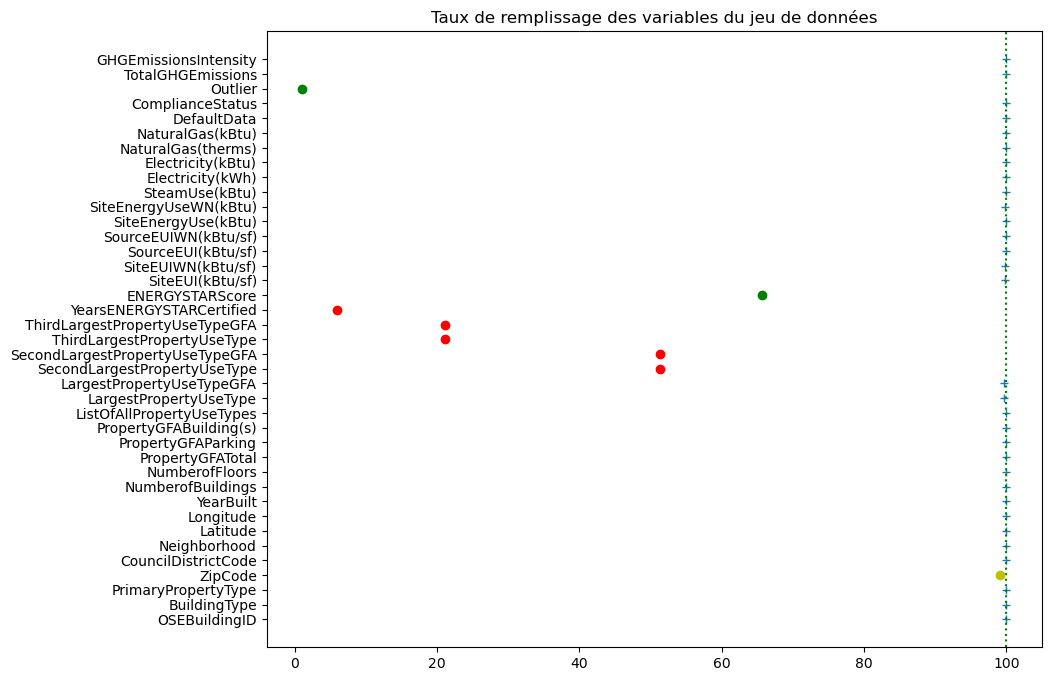

In [19]:
fig = plt.figure(figsize=(10,8))

plt.plot((1-data_nonResidential.isnull().sum().values/len(data_nonResidential))*100, data_nonResidential.isnull().sum().index,
         linestyle='', marker = '+')
plt.axvline(100, linestyle=':', color='g')

for string in features_empty_del:
    plt.plot((100-data_nonResidential[string].isnull().sum()/len(data_nonResidential)*100), np.where(data_nonResidential.columns==string)[0][0],
            'ro')

for string in features_empty_stay:
    plt.plot((100-data_nonResidential[string].isnull().sum()/len(data_nonResidential)*100), np.where(data_nonResidential.columns==string)[0][0],
            'go')

for string in features_notFull:
    plt.plot((100-data_nonResidential[string].isnull().sum()/len(data_nonResidential)*100), np.where(data_nonResidential.columns==string)[0][0],
            'yo')

plt.title('Taux de remplissage des variables du jeu de données')

plt.show()

## Remplissage des variables géographiques

### Traitement ZipCode

#### Seuil de valeurs identiques

In [20]:
ZipCode_nbFull = 3

#### Recensement des codes à remplacer

In [21]:
ZipCode_valuesEmpty = data_nonResidential['ZipCode'].value_counts().loc[
data_nonResidential['ZipCode'].value_counts().values<ZipCode_nbFull].index

#### Répartition avant traitement

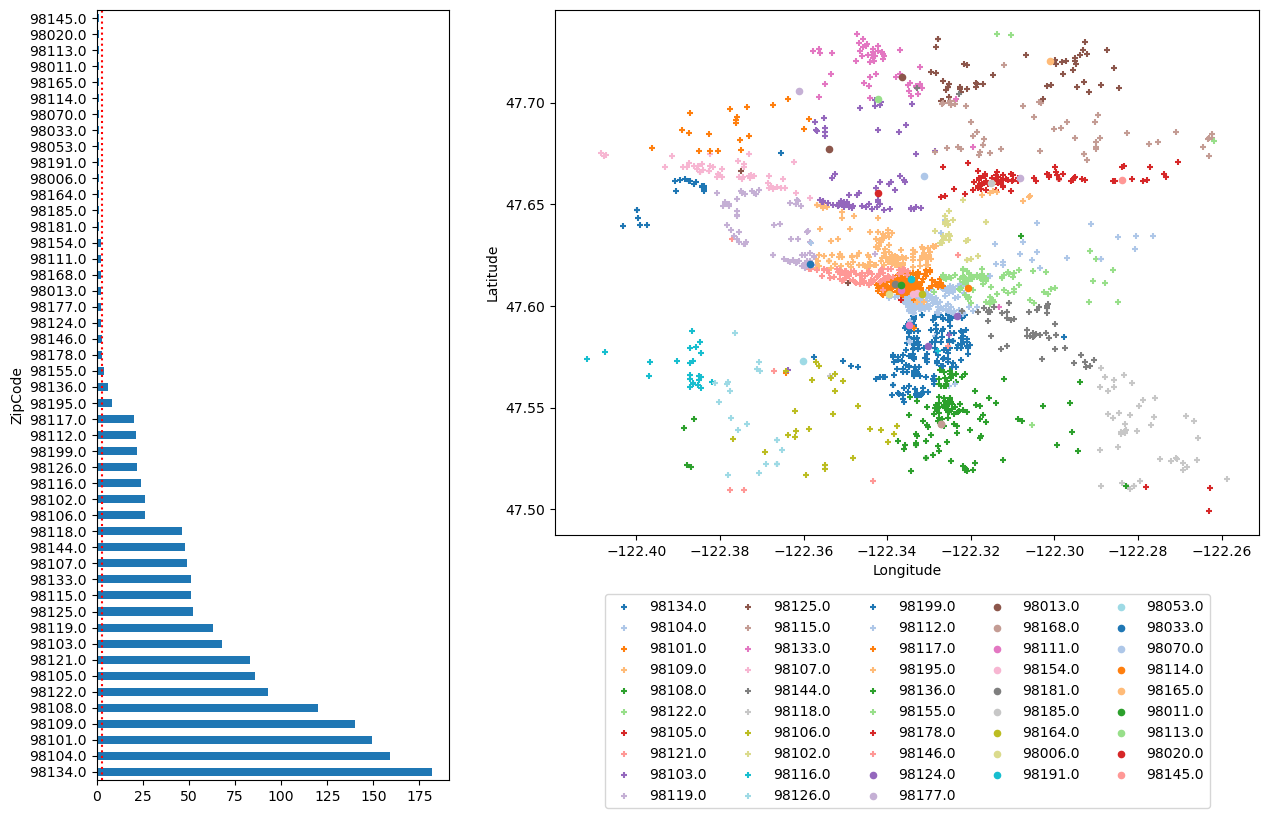

In [22]:
f, axd = plt.subplot_mosaic([['left', 'right'],['left', '.']], height_ratios=[3, 1], width_ratios=[1, 2], figsize=(15, 10))
data_nonResidential['ZipCode'].value_counts().plot(ax=axd['left'], kind='barh')
axd['left'].axvline(ZipCode_nbFull, linestyle=':', c='r')

for i in range(len(data_nonResidential['ZipCode'].value_counts().index)):
    if(data_nonResidential['ZipCode'].value_counts().values[i]<ZipCode_nbFull):
        marker_used = 'o'
    else:
        marker_used = '+'
    data_nonResidential.loc[data_nonResidential['ZipCode']==data_nonResidential['ZipCode'].value_counts().index[i]].plot(
        ax=axd['right'], kind='scatter', x='Longitude', y='Latitude',color=plt.cm.tab20.colors[i%20], marker=marker_used,
        label=data_nonResidential['ZipCode'].value_counts().index[i])

axd['right'].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

plt.show()

#### Traitement

In [23]:
data_nonResidential['ZipCodeFull'] = data_nonResidential['ZipCode']

In [24]:
data_nonResidential.loc[data_nonResidential['ZipCodeFull'].isin(ZipCode_valuesEmpty), 'ZipCodeFull']=np.NaN

##### Nombre de valeurs à remplacer (car trop peu nombreuses)

In [25]:
data_nonResidential['ZipCodeFull'].isnull().sum()-data_nonResidential['ZipCode'].isnull().sum()

26

##### Imputation des valeurs

In [26]:
imputer = KNNImputer(n_neighbors=1)
imputed_data = imputer.fit_transform(data_nonResidential[['Latitude', 'Longitude', 'ZipCodeFull']])
data_nonResidential['ZipCodeFull'] = imputed_data[:,2]

#### Représentation du traitement

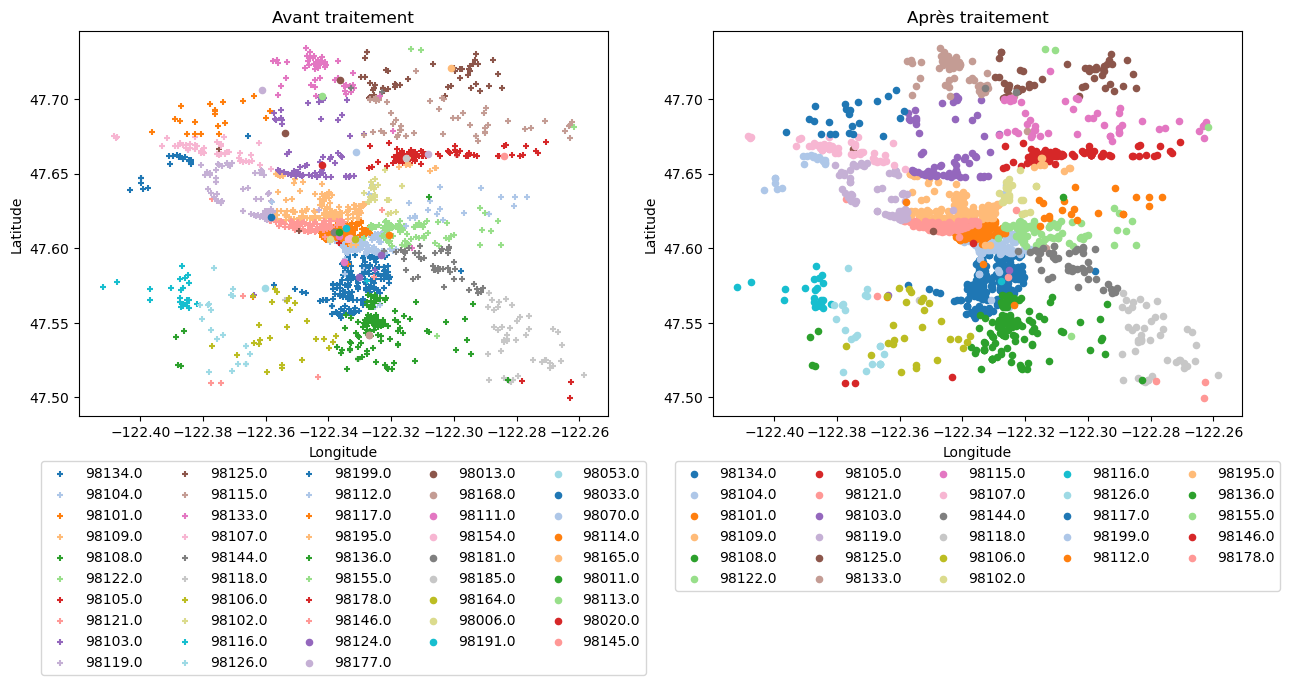

In [27]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)

for i in range(len(data_nonResidential['ZipCode'].value_counts().index)):
    if(data_nonResidential['ZipCode'].value_counts().values[i]<ZipCode_nbFull):
        marker_used = 'o'
    else:
        marker_used = '+'
    data_nonResidential.loc[data_nonResidential['ZipCode']==data_nonResidential['ZipCode'].value_counts().index[i]].plot(
        ax=ax, kind='scatter', x='Longitude', y='Latitude',color=plt.cm.tab20.colors[i%20], marker=marker_used,
        label=data_nonResidential['ZipCode'].value_counts().index[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_title('Avant traitement')

ax = plt.subplot(1,2,2)

for i in range(len(data_nonResidential['ZipCodeFull'].value_counts().index)):
    data_nonResidential.loc[data_nonResidential['ZipCodeFull']==data_nonResidential['ZipCodeFull'].value_counts().index[i]].plot(
        ax=ax, kind='scatter', x='Longitude', y='Latitude',color=plt.cm.tab20.colors[i%20],
        label=data_nonResidential['ZipCodeFull'].value_counts().index[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_title('Après traitement')

plt.show()

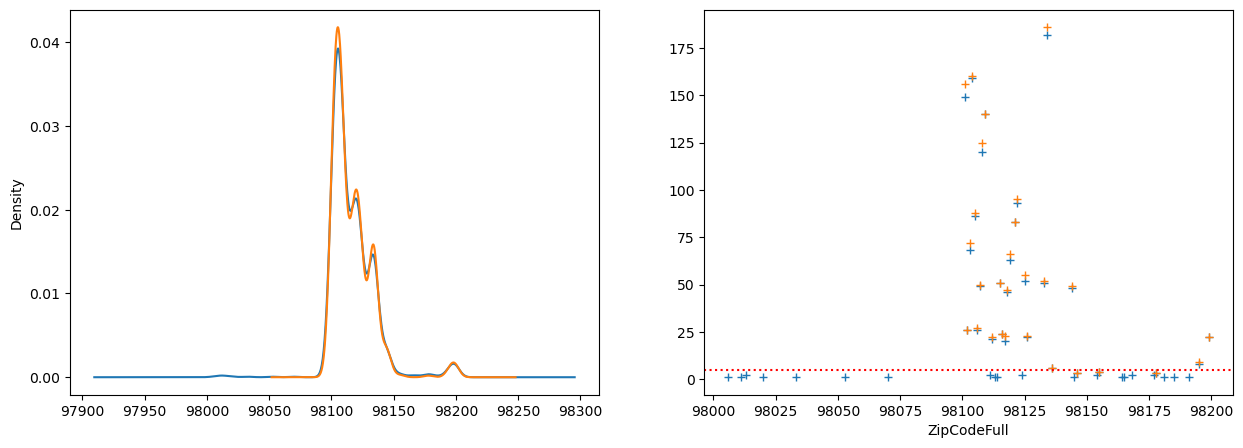

In [28]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
data_nonResidential['ZipCode'].plot(ax=ax, kind='density')
data_nonResidential['ZipCodeFull'].plot(ax=ax, kind='density')

ax = plt.subplot(1,2,2)
data_nonResidential['ZipCode'].value_counts().plot(ax=ax, linestyle='', marker='+')
data_nonResidential['ZipCodeFull'].value_counts().plot(ax=ax, linestyle='', marker='+')
ax.axhline(5, linestyle=':', c='r')

plt.show()

### Harmonisation Neighborhood

In [29]:
data_nonResidential['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                  361
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                148
NORTHEAST                 127
EAST                      121
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

In [30]:
data_nonResidential['Neighborhood'] = data_nonResidential['Neighborhood'].str.upper()
data_nonResidential['Neighborhood'] = data_nonResidential['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

In [31]:
data_nonResidential['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                 361
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               148
NORTHEAST                127
EAST                     121
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   56
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
Name: count, dtype: int64

## Filtrage des bâtiments dont il manque des données

In [32]:
data_nonResidential['nb_val_loss'] = data_nonResidential[features_full].isnull().sum(axis=1)

In [33]:
data_nonResidential['nb_val_loss'].value_counts()

nb_val_loss
0     1659
2        5
17       2
1        1
Name: count, dtype: int64

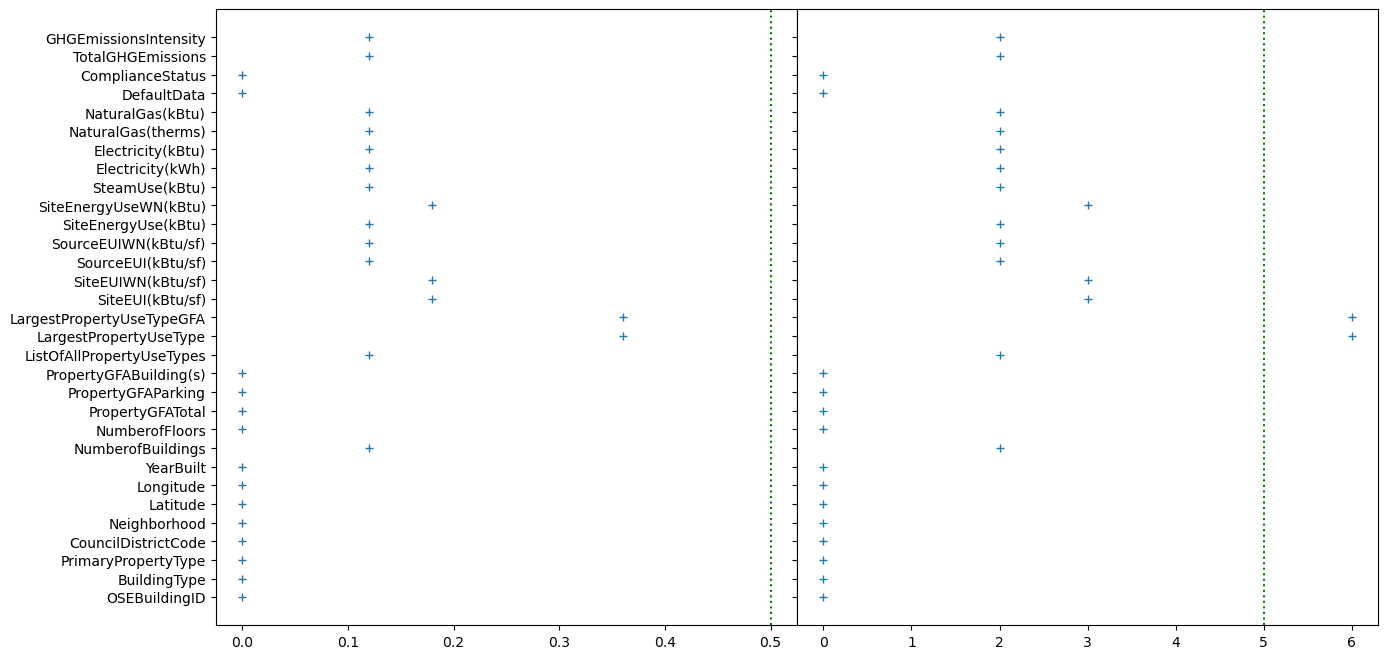

In [34]:
f, axd=plt.subplot_mosaic([['left', 'right']], sharey=True, figsize=(15,8))

axd['left'].plot(data_nonResidential[features_full].isnull().sum().values/len(data_nonResidential[features_full])*100,
                 data_nonResidential[features_full].isnull().sum().index,
         linestyle='', marker = '+')
axd['left'].axvline(0.5, linestyle=':', color='g')

axd['right'].plot(data_nonResidential[features_full].isnull().sum().values,
                  data_nonResidential[features_full].isnull().sum().index,
         linestyle='', marker = '+')
axd['right'].axvline(5, linestyle=':', color='g')

plt.subplots_adjust(wspace=0)

plt.show()

In [35]:
data_full = data_nonResidential.loc[~data_nonResidential[feature_goal1].isnull()].copy()

In [36]:
data_full['nb_val_loss'] = data_full[features_full].isnull().sum(axis=1)

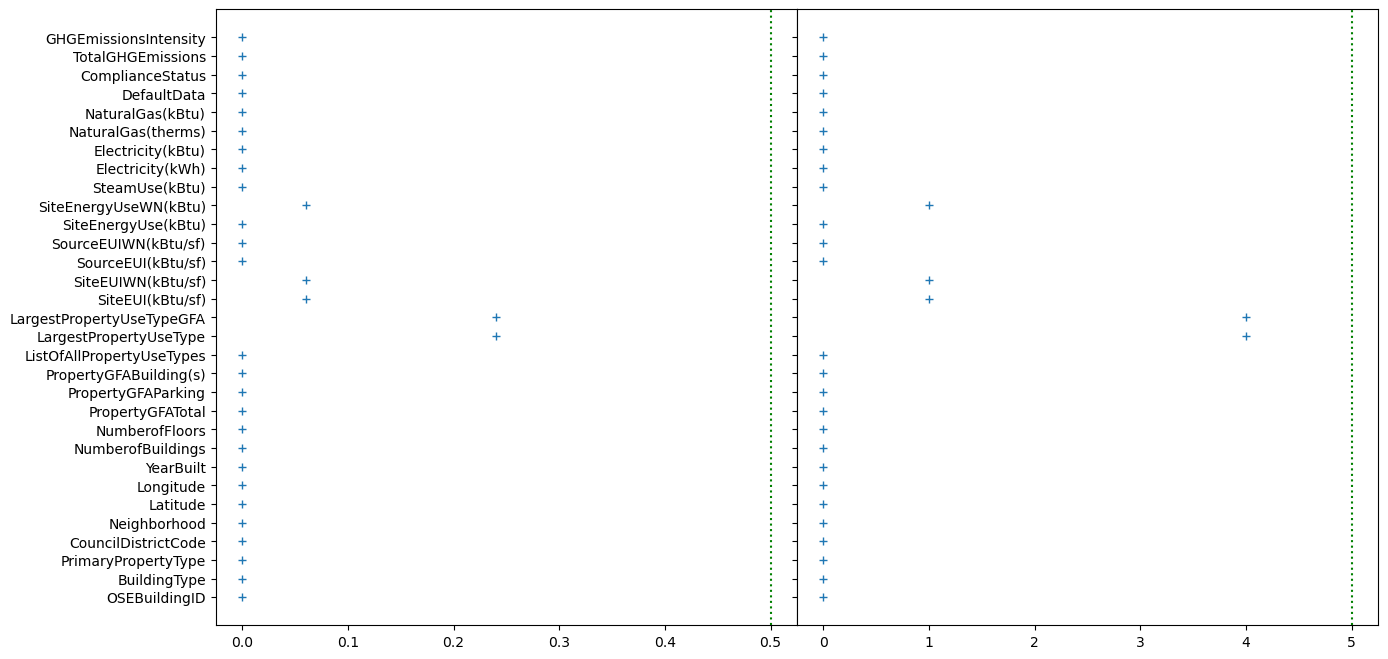

In [37]:
f, axd=plt.subplot_mosaic([['left', 'right']], sharey=True, figsize=(15,8))

axd['left'].plot(data_full[features_full].isnull().sum().values/len(data_full[features_full])*100,
                 data_full[features_full].isnull().sum().index,
         linestyle='', marker = '+')
axd['left'].axvline(0.5, linestyle=':', color='g')

axd['right'].plot(data_full[features_full].isnull().sum().values,
                  data_full[features_full].isnull().sum().index,
         linestyle='', marker = '+')
axd['right'].axvline(5, linestyle=':', color='g')

plt.subplots_adjust(wspace=0)

plt.show()

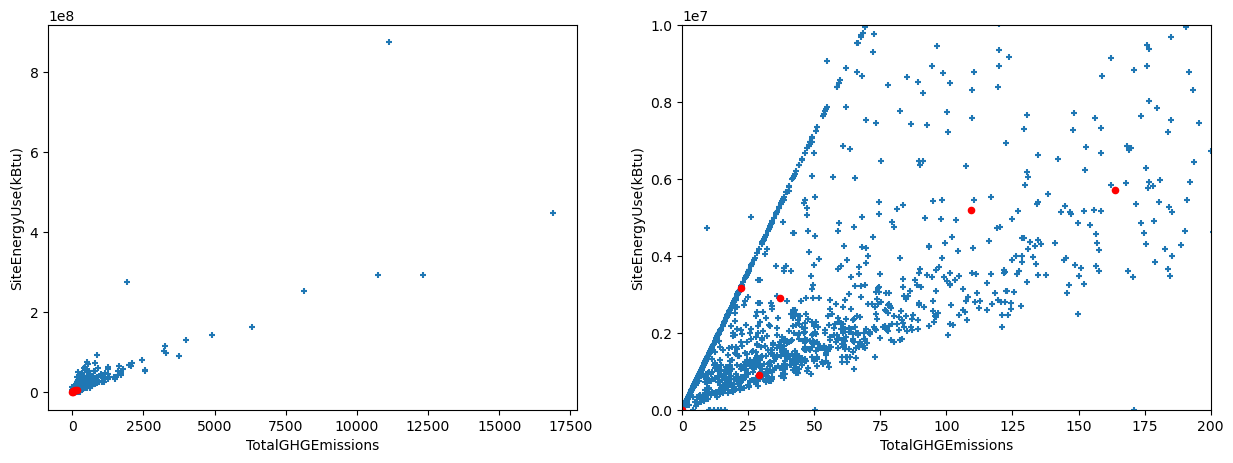

In [38]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
data_full.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, marker='+')
data_full.loc[data_full['nb_val_loss']>0].plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, color='r')

ax=plt.subplot(1,2,2)
data_full.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, marker='+')
data_full.loc[data_full['nb_val_loss']>0].plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, color='r')
plt.xlim(0,200)
plt.ylim(0,1e7)
plt.show()

In [39]:
data_full = data_full.loc[data_full['nb_val_loss']==0]

In [40]:
data_full[features_full].isnull().sum().sum()

0

In [41]:
bat_filter_dict = {}

In [42]:
bat_filter_dict['empty'] = len(data_nonResidential)-len(data_full)

## Calcul de variables et filtrage

### Variables calculées

In [43]:
data_full['SiteEnergyUse_Calc'] = data_full['PropertyGFATotal']*data_full['SiteEUI(kBtu/sf)']

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_4376\1179803368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full['SiteEnergyUse_Calc'] = data_full['PropertyGFATotal']*data_full['SiteEUI(kBtu/sf)']


In [44]:
data_full['TotalGHGEmissions_Calc'] = data_full['PropertyGFATotal']*data_full['GHGEmissionsIntensity']/1000

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_4376\3827984090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full['TotalGHGEmissions_Calc'] = data_full['PropertyGFATotal']*data_full['GHGEmissionsIntensity']/1000


In [45]:
data_full['Energy(kBtu)'] = data_full[features_categoriesEnergykBtu].sum(axis=1)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_4376\2000194056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full['Energy(kBtu)'] = data_full[features_categoriesEnergykBtu].sum(axis=1)


In [46]:
for i in range(3):
    data_full[features_categoriesEnergyProp[i]] = data_full[features_categoriesEnergykBtu[i]]/data_full['Energy(kBtu)']*100

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_4376\4141784495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full[features_categoriesEnergyProp[i]] = data_full[features_categoriesEnergykBtu[i]]/data_full['Energy(kBtu)']*100
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_4376\4141784495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full[features_categoriesEnergyProp[i]] = data_full[features_categoriesEnergykBtu[i]]/data_full['Energy(kBtu)']*100
C:\Users\Jonathan\AppData\Local\Temp\ipyke

### Filtrage des bâtiments selon les variables

### Filtrage

In [47]:
data_inliers = data_full.loc[data_full[features_architecture[1]]!=111].copy()
data_outliers = data_full.loc[data_full[features_architecture[1]]==111].copy()

In [48]:
data_outliers = pd.concat([data_outliers, data_full.loc[data_full['SiteEnergyUse(kBtu)']>4e8].copy()])
data_inliers = data_inliers.loc[data_inliers['SiteEnergyUse(kBtu)']<=4e8]

In [49]:
data_outliers = pd.concat([data_outliers, data_full.loc[(data_full['SiteEnergyUse(kBtu)']>1e8)&(data_full['SiteEnergyUse_Calc']<1e8)].copy()])
data_inliers = data_inliers.loc[(data_inliers['SiteEnergyUse(kBtu)']<=1e8)|(data_inliers['SiteEnergyUse_Calc']>=1e8)]

In [50]:
data_high = data_inliers.loc[data_inliers['SiteEnergyUse(kBtu)']>2e8].copy()

In [51]:
data_WNerror = data_inliers.loc[(data_inliers[features_siteEnergy[1]]==0)&(data_inliers[features_siteEnergy[0]]!=0)]
data_inliers = data_inliers.loc[(data_inliers[features_siteEnergy[1]]!=0)|(data_inliers[features_siteEnergy[0]]==0)]

In [52]:
data_NBerror = data_inliers.loc[(data_inliers[features_architecture[1]]==0)]
data_inliers = data_inliers.loc[(data_inliers[features_architecture[1]]!=0)]

In [53]:
data_NFerror = data_inliers.loc[(data_inliers[features_architecture[2]]==0)]
data_inliers = data_inliers.loc[(data_inliers[features_architecture[2]]!=0)]

In [54]:
data_gnegative = data_inliers.loc[(data_inliers[feature_goal1]<=0)|(data_inliers[feature_goal2]<=0)|
    (data_inliers[feature_goal1_int]<=0)|(data_inliers[feature_goal2_int]<=0)]
data_inliers = data_inliers.loc[(data_inliers[feature_goal1]>0)&(data_inliers[feature_goal2]>0)&
    (data_inliers[feature_goal1_int]>0)&(data_inliers[feature_goal2_int]>0)]

In [55]:
data_Ferror = data_inliers.loc[data_inliers[features_architecture[2]]>90]
data_inliers = data_inliers.loc[data_inliers[features_architecture[2]]<=90]

### Nombres de bâtiments supprimés

In [56]:
bat_filter_dict['outliers'] = len(data_outliers)

In [57]:
bat_filter_dict['Weather normalized'] = len(data_WNerror)

In [58]:
bat_filter_dict[features_architecture[1]] = len(data_NBerror)

In [59]:
bat_filter_dict[features_architecture[2]] = len(data_NFerror)

In [60]:
bat_filter_dict['goal<0'] = len(data_gnegative)

In [61]:
bat_filter_dict['Floors>90'] = len(data_gnegative)

### Position des bâtiments supprimés dans le plan des variables cibles

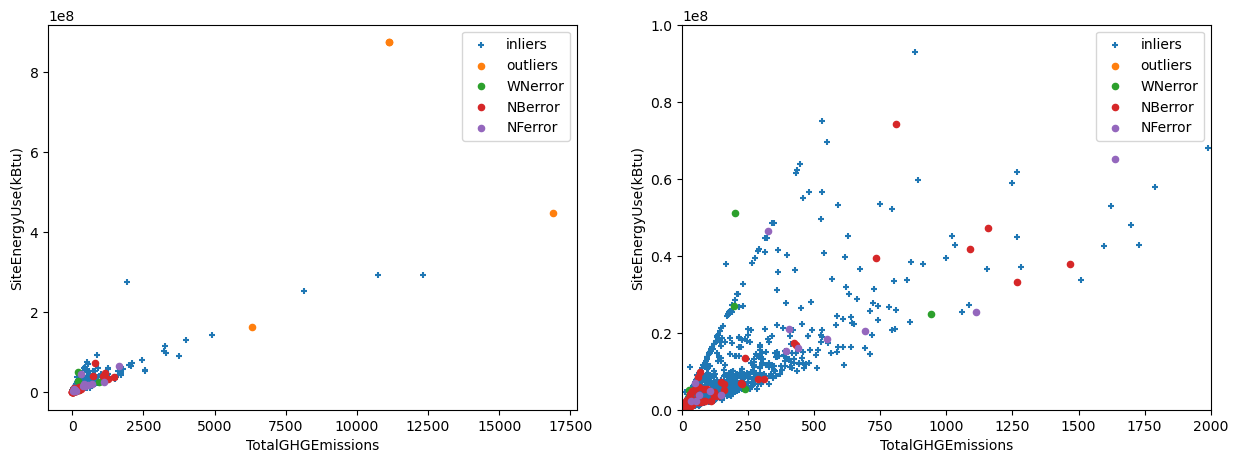

In [62]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
data_inliers.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, marker='+', label='inliers')
data_outliers.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='outliers', color=plt.cm.tab10.colors[1])
data_WNerror.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='WNerror', color=plt.cm.tab10.colors[2])
data_NBerror.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='NBerror', color=plt.cm.tab10.colors[3])
data_NFerror.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='NFerror', color=plt.cm.tab10.colors[4])

ax=plt.subplot(1,2,2)
data_inliers.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, marker='+', label='inliers')
data_outliers.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='outliers', color=plt.cm.tab10.colors[1])
data_WNerror.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='WNerror', color=plt.cm.tab10.colors[2])
data_NBerror.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='NBerror', color=plt.cm.tab10.colors[3])
data_NFerror.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, label='NFerror', color=plt.cm.tab10.colors[4])
plt.xlim(0,2000)
plt.ylim(0,1e8)

plt.show()

### Vérification des calculs et filtrages

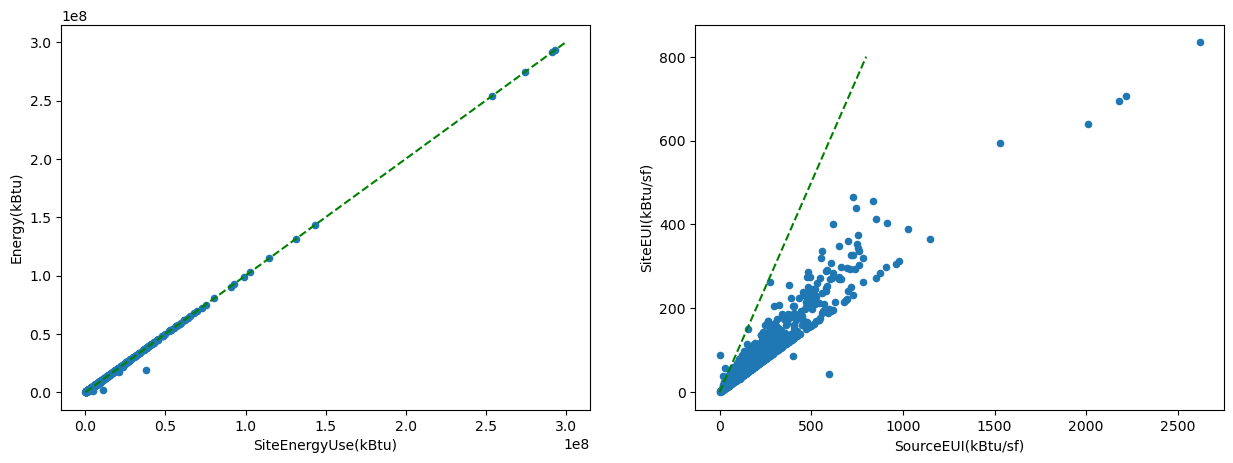

In [63]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
data_inliers.plot(ax=ax, kind='scatter', x='SiteEnergyUse(kBtu)', y='Energy(kBtu)')
ax.plot([0, 3e8], [0,3e8], '--g')

ax=plt.subplot(1,2,2)
data_inliers.plot(ax=ax, kind='scatter', x='SourceEUI(kBtu/sf)', y='SiteEUI(kBtu/sf)')
ax.plot([0, 800], [0,800], '--g')

plt.show()

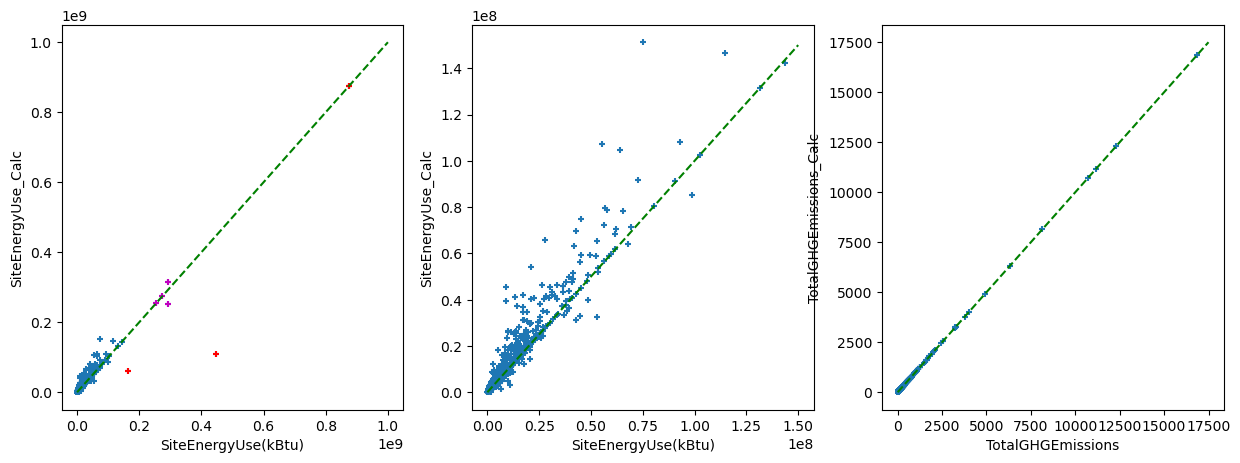

In [64]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
data_full.plot(ax=ax, kind='scatter', x='SiteEnergyUse(kBtu)', y='SiteEnergyUse_Calc', marker='+')
ax.plot([0, 1e9], [0,1e9], '--g')
data_outliers.plot(ax=ax, kind='scatter', x='SiteEnergyUse(kBtu)', y='SiteEnergyUse_Calc', marker='+', color='r')
data_high.plot(ax=ax, kind='scatter', x='SiteEnergyUse(kBtu)', y='SiteEnergyUse_Calc', marker='+', color='m')

ax=plt.subplot(1,3,2)
data_inliers.loc[data_inliers['SiteEnergyUse(kBtu)']<2e8].plot(ax=ax, kind='scatter', x='SiteEnergyUse(kBtu)', y='SiteEnergyUse_Calc', marker='+')
ax.plot([0, 1.5e8], [0,1.5e8], '--g')

ax=plt.subplot(1,3,3)
data_full.plot(ax=ax, kind='scatter', x='TotalGHGEmissions', y='TotalGHGEmissions_Calc', marker='+')
ax.plot([0, 17500], [0, 17500], '--g')

plt.show()

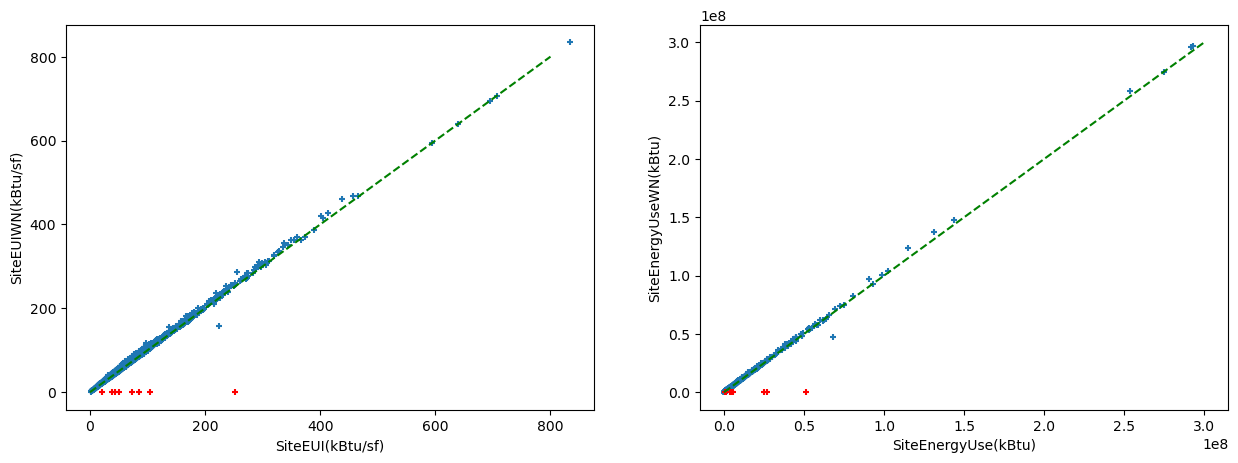

In [65]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
data_inliers.plot(ax=ax, kind='scatter', x=features_siteEnergy[0], y=features_siteEnergy[1], marker='+')
data_WNerror.plot(ax=ax, kind='scatter', x=features_siteEnergy[0], y=features_siteEnergy[1], marker='+', color='r')
ax.plot([0, 800], [0, 800], '--g')

ax = plt.subplot(1,2,2)
data_inliers.plot(ax=ax, kind='scatter', x=features_siteEnergy[2], y=features_siteEnergy[3], marker='+')
data_WNerror.plot(ax=ax, kind='scatter', x=features_siteEnergy[2], y=features_siteEnergy[3], marker='+', color='r')
ax.plot([0, 3e8], [0, 3e8], '--g')

plt.show()

## Variables d'intérêt

### Catégories

#### Avant amélioration

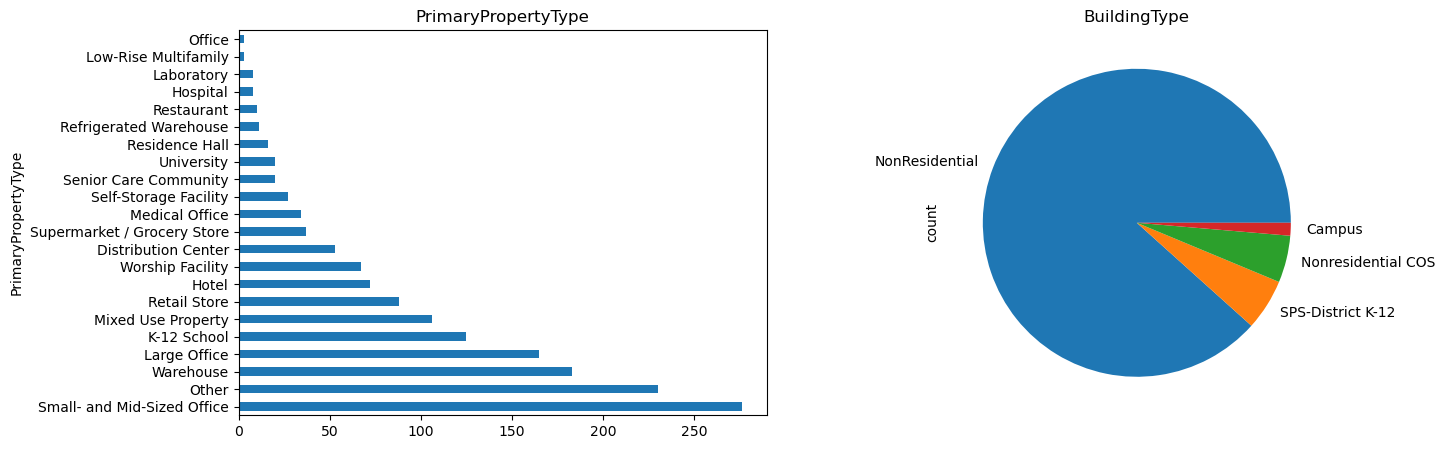

In [66]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,2)
data_inliers[features_categories[0]].value_counts().plot(ax=ax, kind='pie')
ax.set_title(features_categories[0])

ax = plt.subplot(1,2,1)
data_inliers[features_categories[1]].value_counts().plot(ax=ax, kind='barh')
ax.set_title(features_categories[1])

plt.show()

#### Amélioration des catégories

In [67]:
data_inliers.loc[(data_inliers[features_categories[1]]=='Mixed Use Property')
&(data_inliers[features_empty_del[0]]=='Data Center'), features_categories[1]]='Data Center'

In [68]:
data_inliers.loc[data_inliers[features_categories[1]].isin(['Other', 'Mixed Use Property']),
    features_categories[1]]=data_inliers.loc[data_inliers[features_categories[1]].isin(['Other', 'Mixed Use Property']), features_use[1]]

In [69]:
categories_low = data_inliers[features_categories[1]].value_counts().loc[data_inliers[features_categories[1]].value_counts()<=5].index

In [70]:
categories_exclude = ['Data Center', 'Urgent Care/Clinic/Other Outpatient', 'Hospital']

In [71]:
data_inliers.loc[(data_inliers[features_categories[1]].isin(categories_low))
    &~(data_inliers[features_categories[1]].isin(categories_exclude)), features_categories[1]] = 'Other'

In [72]:
data_inliers[features_categories[1]] = data_inliers[features_categories[1]].replace('Others', 'Other')

In [73]:
data_inliers.loc[(data_inliers[features_categories[1]]=='Other')
    &(data_inliers[features_use[1]].isin(['Strip Mall', 'Other - Mall'])), features_categories[1]]='Mall'

In [74]:
data_inliers.loc[(data_inliers[features_categories[1]]=='Other')
    &(data_inliers[features_use[1]]=='Other/Specialty Hospital'), features_categories[1]]='Hospital'

In [75]:
data_inliers.loc[(data_inliers[features_categories[1]]=='Other')
    &(data_inliers[features_use[1]].isin(['Museum', 'Fitness Center/Health Club/Gym'])), features_categories[1]]='Other - Recreation'

In [76]:
data_inliers.loc[data_inliers[features_categories[1]].isin(['Urgent Care/Clinic/Other Outpatient', 'Hospital', 'Laboratory']),
    features_categories[1]]='Medical'

In [77]:
data_inliers.loc[data_inliers[features_categories[1]].isin(['Manufacturing/Industrial Plant', 'Repair Services (Vehicle, Shoe, Locksmith, etc)']),
    features_categories[1]]='Industrial'

In [78]:
data_inliers[features_categories[1]] = data_inliers[features_categories[1]].replace('Non-Refrigerated Warehouse', 'Warehouse')

#### Après amélioration

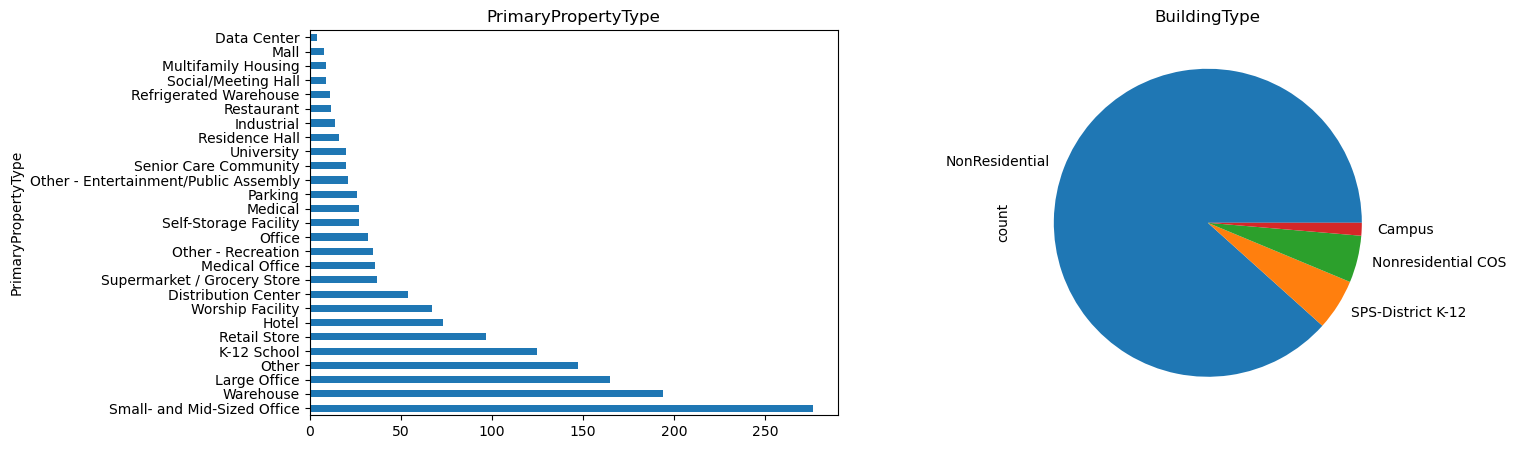

In [79]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,2)
data_inliers[features_categories[0]].value_counts().plot(ax=ax, kind='pie')
ax.set_title(features_categories[0])

ax = plt.subplot(1,2,1)
data_inliers[features_categories[1]].value_counts().plot(ax=ax, kind='barh')
ax.set_title(features_categories[1])

plt.show()

In [80]:
data_inliers[features_categories[1]].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office              276
Warehouse                                194
Large Office                             165
Other                                    147
K-12 School                              125
Retail Store                              97
Hotel                                     73
Worship Facility                          67
Distribution Center                       54
Supermarket / Grocery Store               37
Medical Office                            36
Other - Recreation                        35
Office                                    32
Self-Storage Facility                     27
Medical                                   27
Parking                                   26
Other - Entertainment/Public Assembly     21
Senior Care Community                     20
University                                20
Residence Hall                            16
Industrial                                14
Restaurant                         

### Architecture

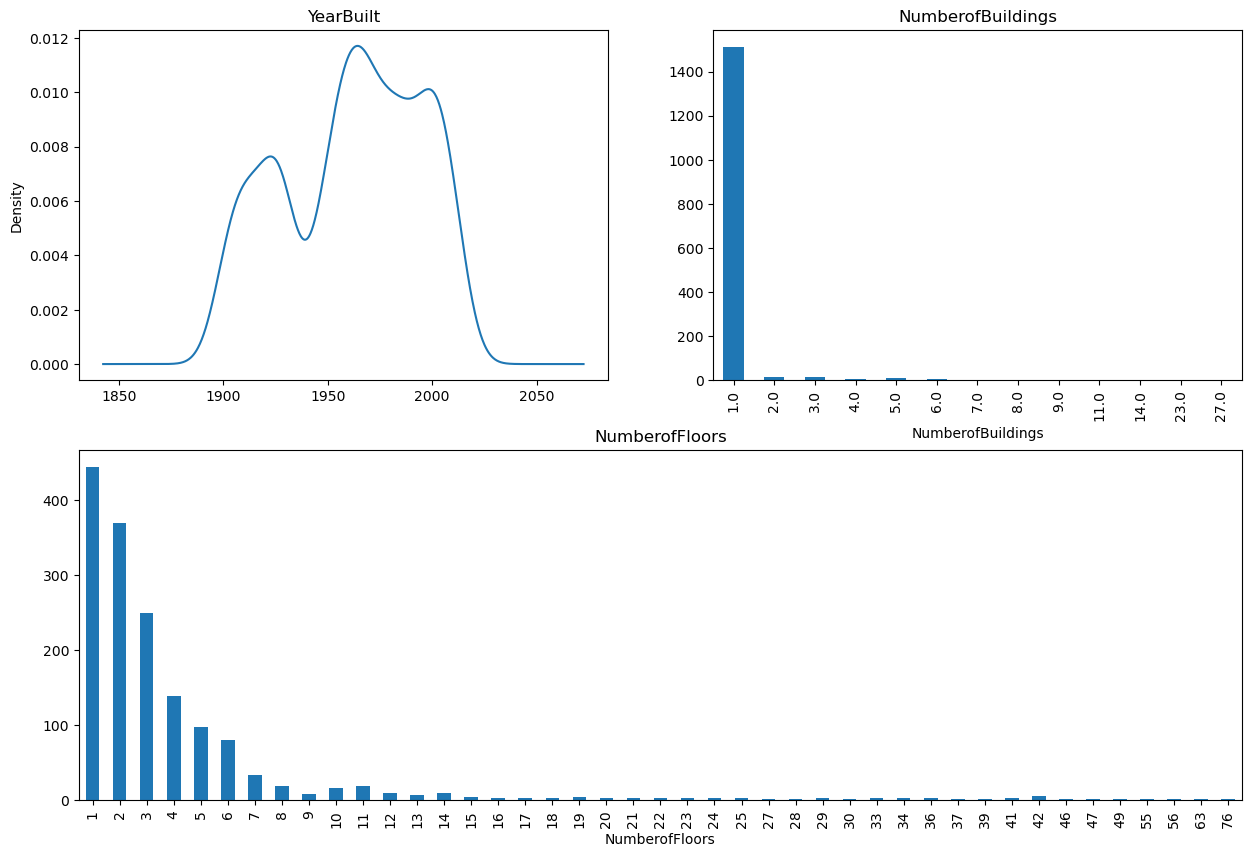

In [81]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(2,2,1)
data_inliers[features_architecture[0]].plot(kind='density')
ax.set_title(features_architecture[0])

ax = plt.subplot(2,2,2)
data_inliers[features_architecture[1]].value_counts().sort_index().plot(kind='bar')
ax.set_title(features_architecture[1])

ax = plt.subplot(2,1,2)
data_inliers[features_architecture[2]].value_counts().sort_index().plot(kind='bar')
ax.set_title(features_architecture[2])

plt.show()

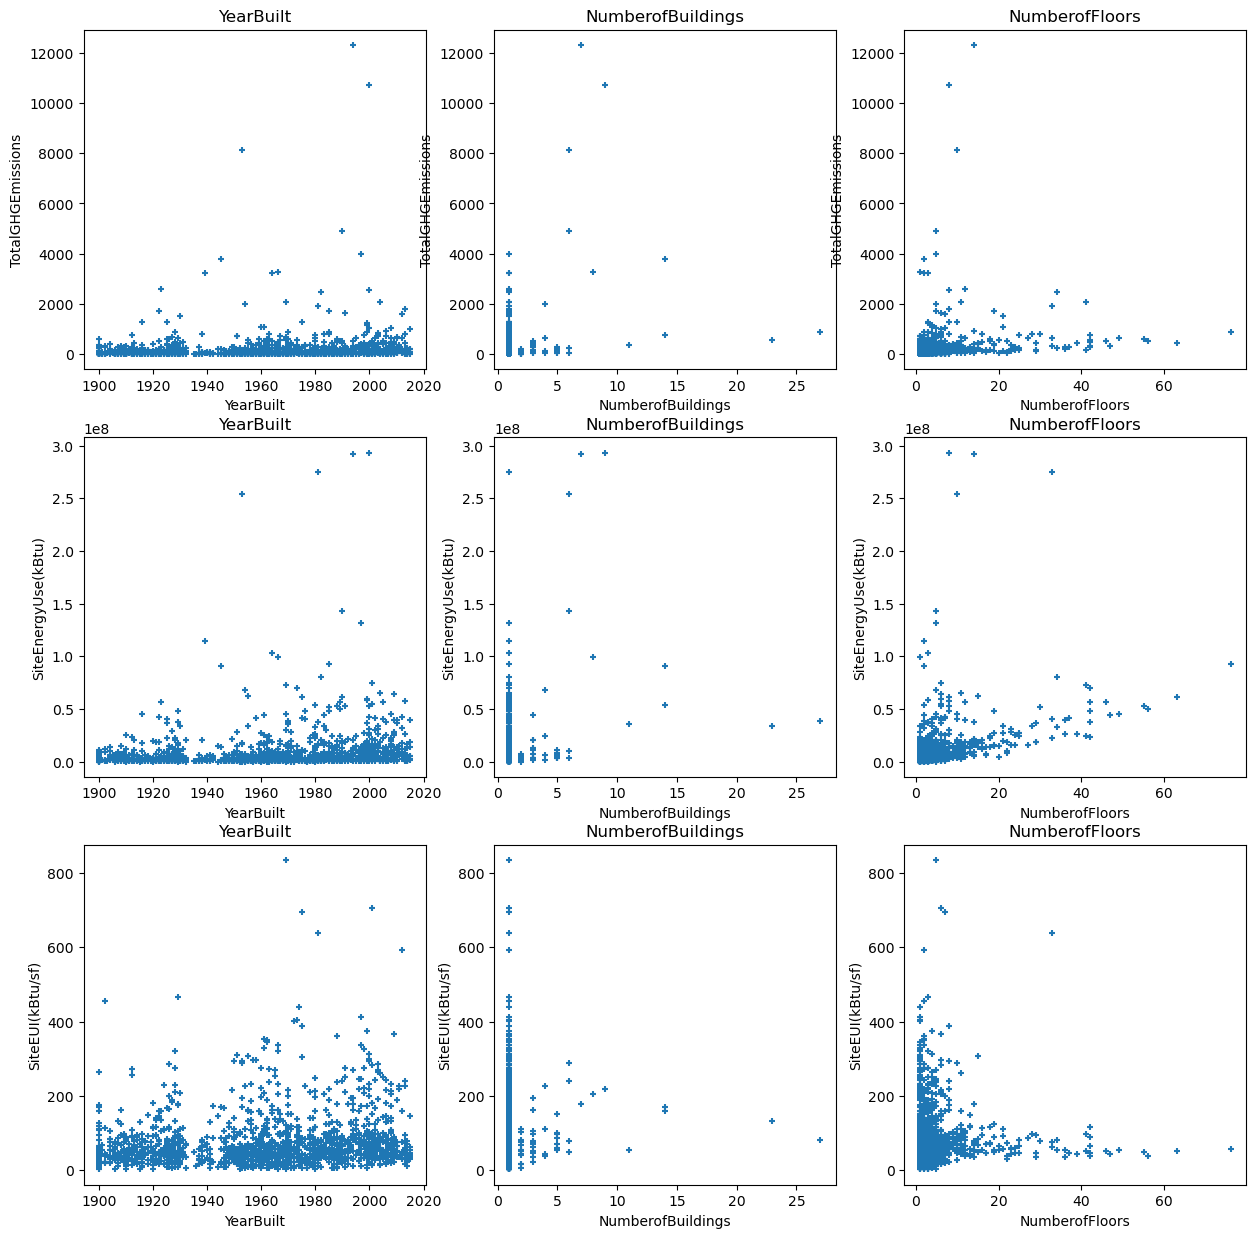

In [82]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot(3,3,1)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[0], y=feature_goal1, marker='+')
ax.set_title(features_architecture[0])

ax = plt.subplot(3,3,2)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[1], y=feature_goal1, marker='+')
ax.set_title(features_architecture[1])

ax = plt.subplot(3,3,3)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[2], y=feature_goal1, marker='+')
ax.set_title(features_architecture[2])

ax = plt.subplot(3,3,4)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[0], y=feature_goal2, marker='+')
ax.set_title(features_architecture[0])

ax = plt.subplot(3,3,5)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[1], y=feature_goal2, marker='+')
ax.set_title(features_architecture[1])

ax = plt.subplot(3,3,6)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[2], y=feature_goal2, marker='+')
ax.set_title(features_architecture[2])

ax = plt.subplot(3,3,7)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[0], y=features_siteEnergy[0], marker='+')
ax.set_title(features_architecture[0])

ax = plt.subplot(3,3,8)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[1], y=features_siteEnergy[0], marker='+')
ax.set_title(features_architecture[1])

ax = plt.subplot(3,3,9)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[2], y=features_siteEnergy[0], marker='+')
ax.set_title(features_architecture[2])

plt.show()

Text(0.5, 1.0, 'NumberofFloors')

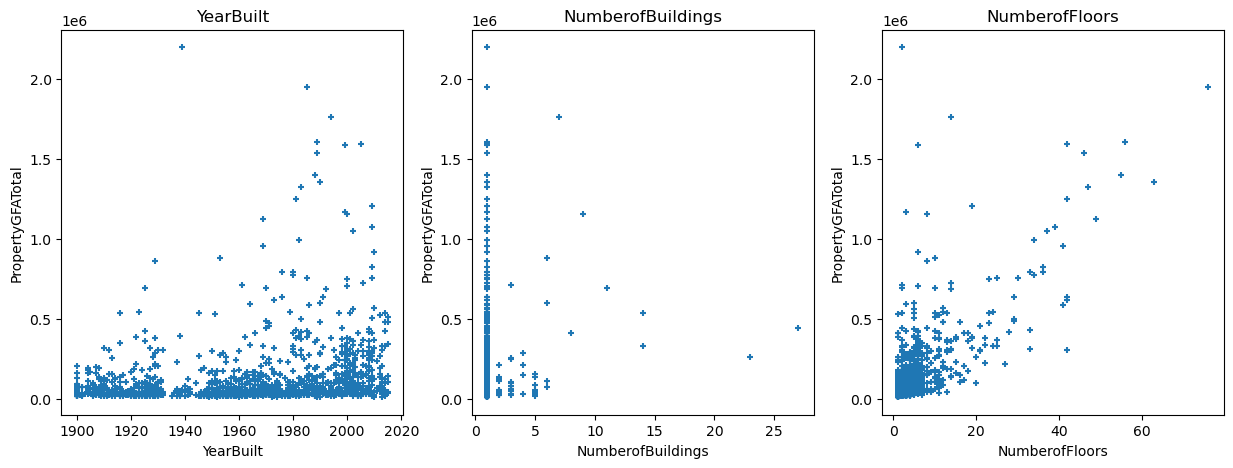

In [83]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[0], y=features_GFA[0], marker='+')
ax.set_title(features_architecture[0])

ax = plt.subplot(1,3,2)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[1], y=features_GFA[0], marker='+')
ax.set_title(features_architecture[1])

ax = plt.subplot(1,3,3)
data_inliers.plot(ax=ax, kind='scatter', x=features_architecture[2], y=features_GFA[0], marker='+')
ax.set_title(features_architecture[2])

### Surface (GFA)

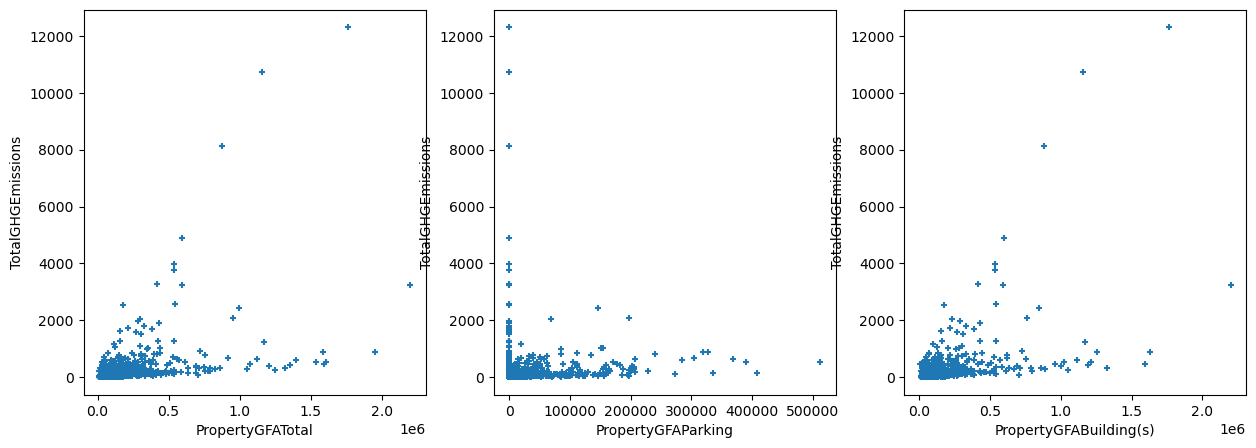

In [84]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)
data_inliers.plot(ax=ax, kind='scatter', x=features_GFA[0], y=feature_goal1, marker='+')

ax = plt.subplot(1,3,2)
data_inliers.plot(ax=ax, kind='scatter', x=features_GFA[1], y=feature_goal1, marker='+')

ax = plt.subplot(1,3,3)
data_inliers.plot(ax=ax, kind='scatter', x=features_GFA[2], y=feature_goal1, marker='+')

plt.show()

### Types d'énergie

<Axes: ylabel='Density'>

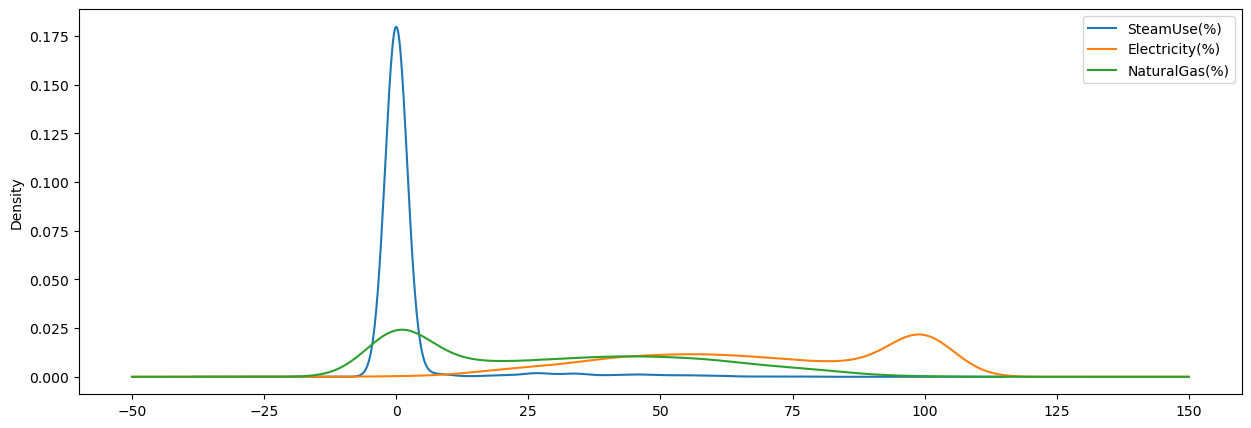

In [85]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,1,1)
data_inliers[features_categoriesEnergyProp].plot(ax=ax, kind='density')

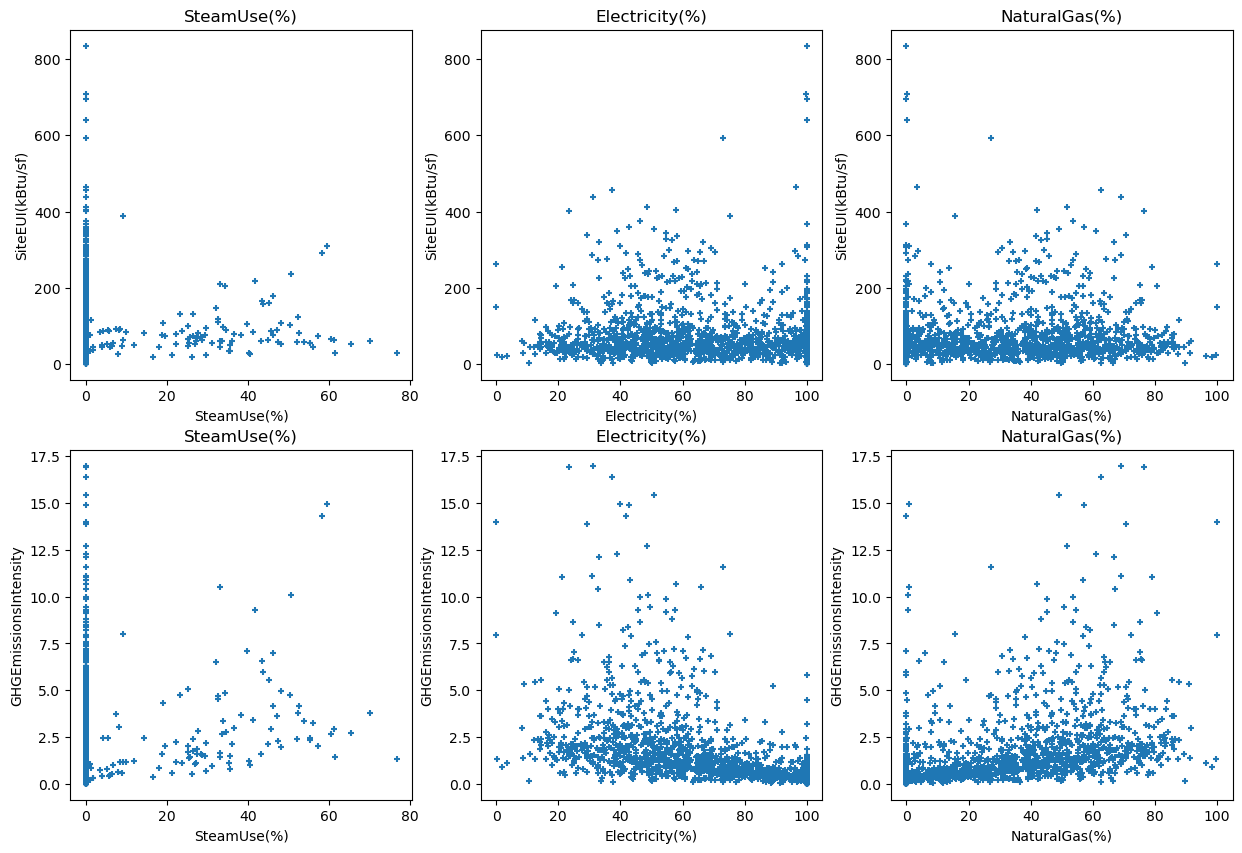

In [86]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(2,3,1)
data_inliers.plot(ax=ax, kind='scatter', x=features_categoriesEnergyProp[0], y=features_siteEnergy[0], marker='+')
ax.set_title(features_categoriesEnergyProp[0])

ax = plt.subplot(2,3,2)
data_inliers.plot(ax=ax, kind='scatter', x=features_categoriesEnergyProp[1], y=features_siteEnergy[0], marker='+')
ax.set_title(features_categoriesEnergyProp[1])

ax = plt.subplot(2,3,3)
data_inliers.plot(ax=ax, kind='scatter', x=features_categoriesEnergyProp[2], y=features_siteEnergy[0], marker='+')
ax.set_title(features_categoriesEnergyProp[2])

ax = plt.subplot(2,3,4)
data_inliers.plot(ax=ax, kind='scatter', x=features_categoriesEnergyProp[0], y=features_GHG[1], marker='+')
ax.set_title(features_categoriesEnergyProp[0])

ax = plt.subplot(2,3,5)
data_inliers.plot(ax=ax, kind='scatter', x=features_categoriesEnergyProp[1], y=features_GHG[1], marker='+')
ax.set_title(features_categoriesEnergyProp[1])

ax = plt.subplot(2,3,6)
data_inliers.plot(ax=ax, kind='scatter', x=features_categoriesEnergyProp[2], y=features_GHG[1], marker='+')
ax.set_title(features_categoriesEnergyProp[2])

plt.show()

### Répartition par catégories

#### Fonction de représentation

In [87]:
def plot_two_features_categories(data, feature1, feature2, category1, category2):

    fig = plt.figure(figsize=(15,20))
    
    ax = plt.subplot(3,2,3)
    data_pivot = pd.pivot_table(data, values=feature1, index=data.index, columns=category1)
    data_pivot.plot(ax=ax, kind='box', vert=False)
    ax.set_title(feature1)
    
    ax = plt.subplot(3,2,4)
    data_pivot = pd.pivot_table(data, values=feature2, index=data.index, columns=category1)
    data_pivot.plot(ax=ax, kind='box', vert=False)
    ax.set_title(feature2)
    ax.yaxis.tick_right()
    
    ax = plt.subplot(3,2,5)
    data_pivot = pd.pivot_table(data, values=feature1, index=data.index, columns=category2)
    data_pivot.plot(ax=ax, kind='box', vert=False)
    ax.set_title(feature1)
    
    ax = plt.subplot(3,2,6)
    data_pivot = pd.pivot_table(data, values=feature2, index=data.index, columns=category2)
    data_pivot.plot(ax=ax, kind='box', vert=False)
    ax.set_title(feature2)
    ax.yaxis.tick_right()
    
    ax = plt.subplot(3,1,1)
    data[feature1].plot(kind='density', label=feature1)
    data[feature2].plot(kind='density', linestyle=':', label=feature2)
    ax.legend()
    
    plt.show()

#### Variables cibles

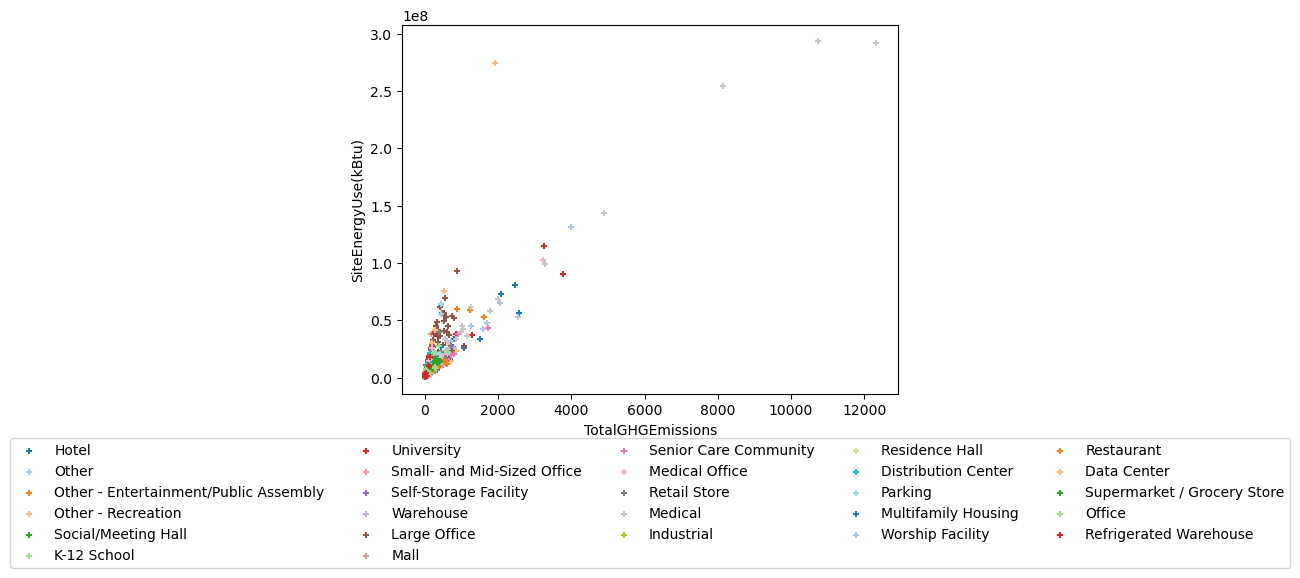

In [88]:
ax = plt.gca()

i=0
for string in data_inliers[features_categories[1]].unique():
    data_inliers.loc[data_inliers[features_categories[1]]==string].plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2,
                                                                        label=string, marker='+', color=plt.cm.tab20.colors[i%20])
    i+=1

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

plt.show()

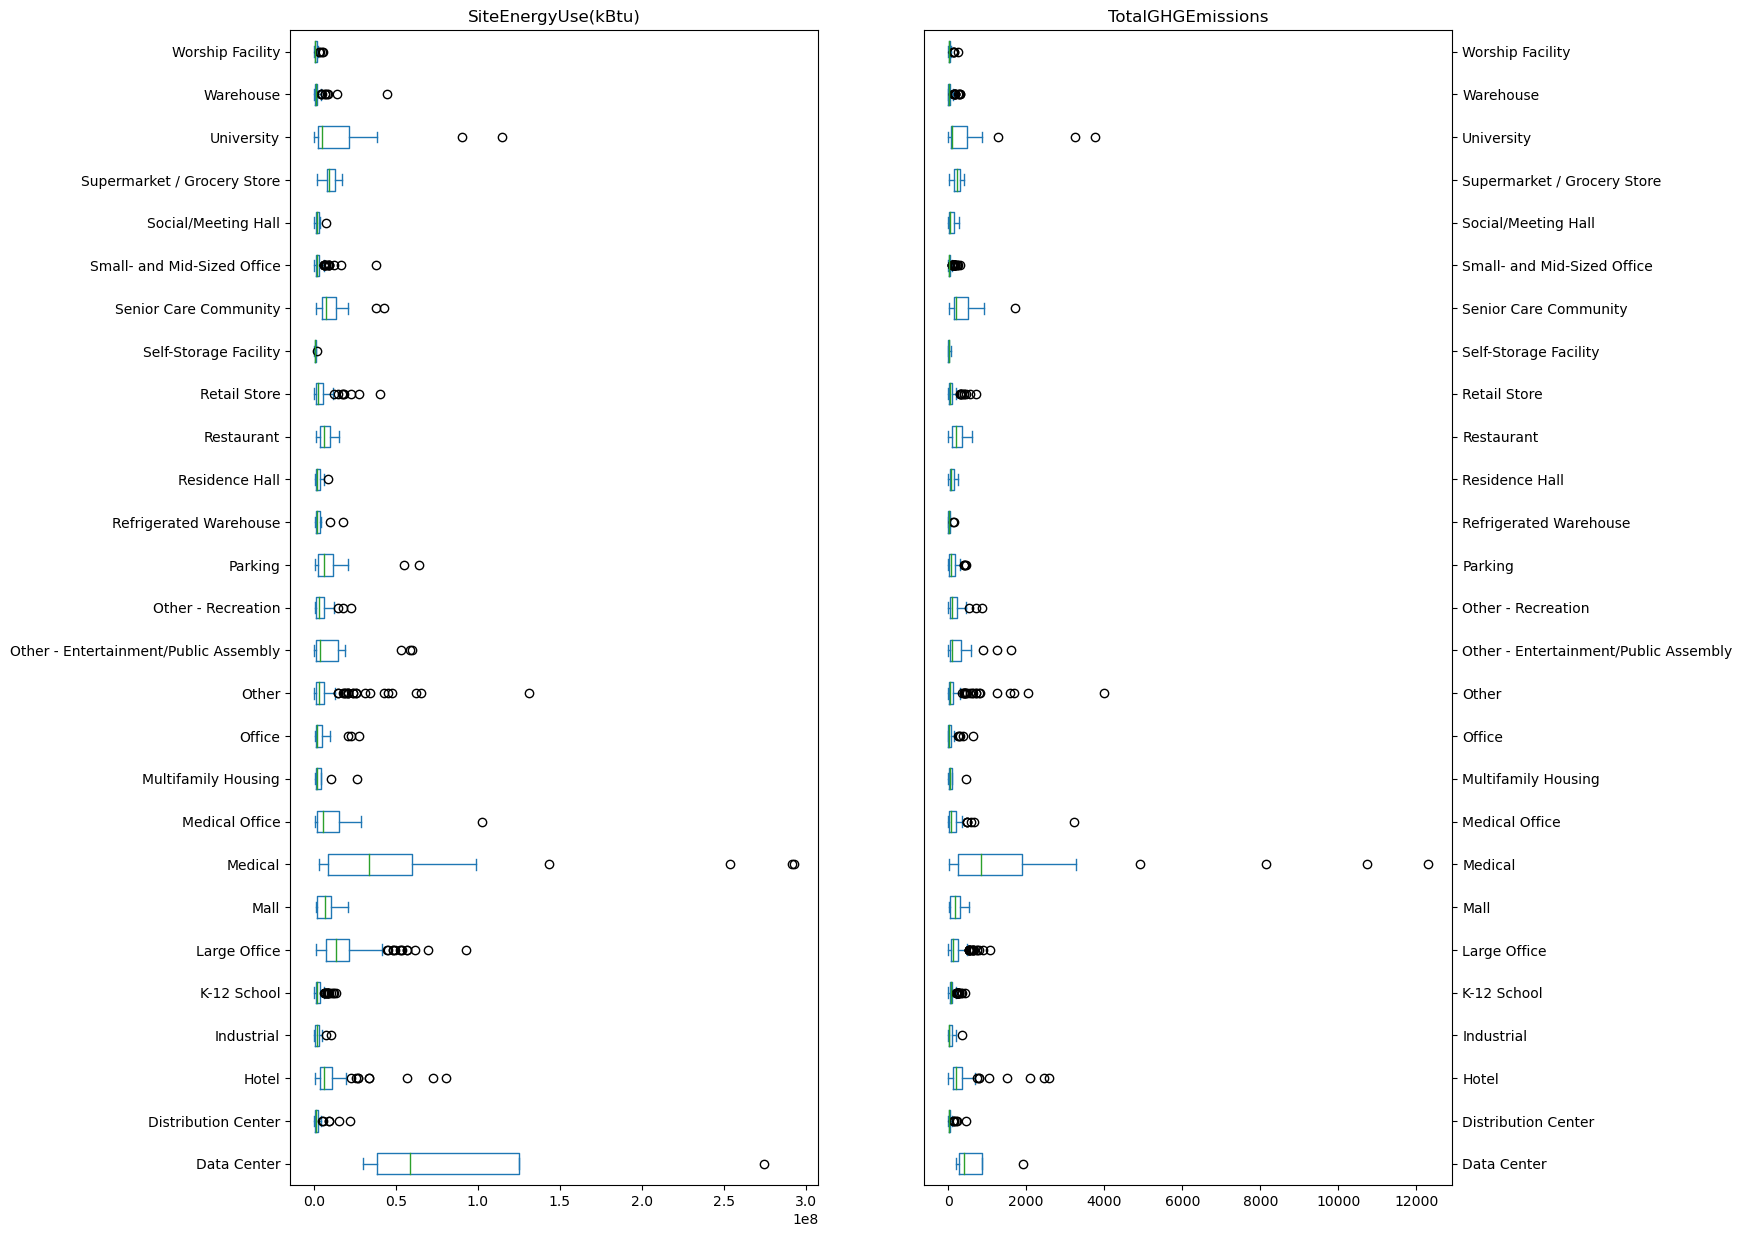

In [89]:
feature1 = feature_goal2
feature2 = feature_goal1
category1 = features_categories[1]

fig = plt.figure(figsize=(15,15))

ax = plt.subplot(1,2,1)
data_pivot = pd.pivot_table(data_inliers, values=feature1, index=data_inliers.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature1)

ax = plt.subplot(1,2,2)
data_pivot = pd.pivot_table(data_inliers, values=feature2, index=data_inliers.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature2)
ax.yaxis.tick_right()

plt.show()

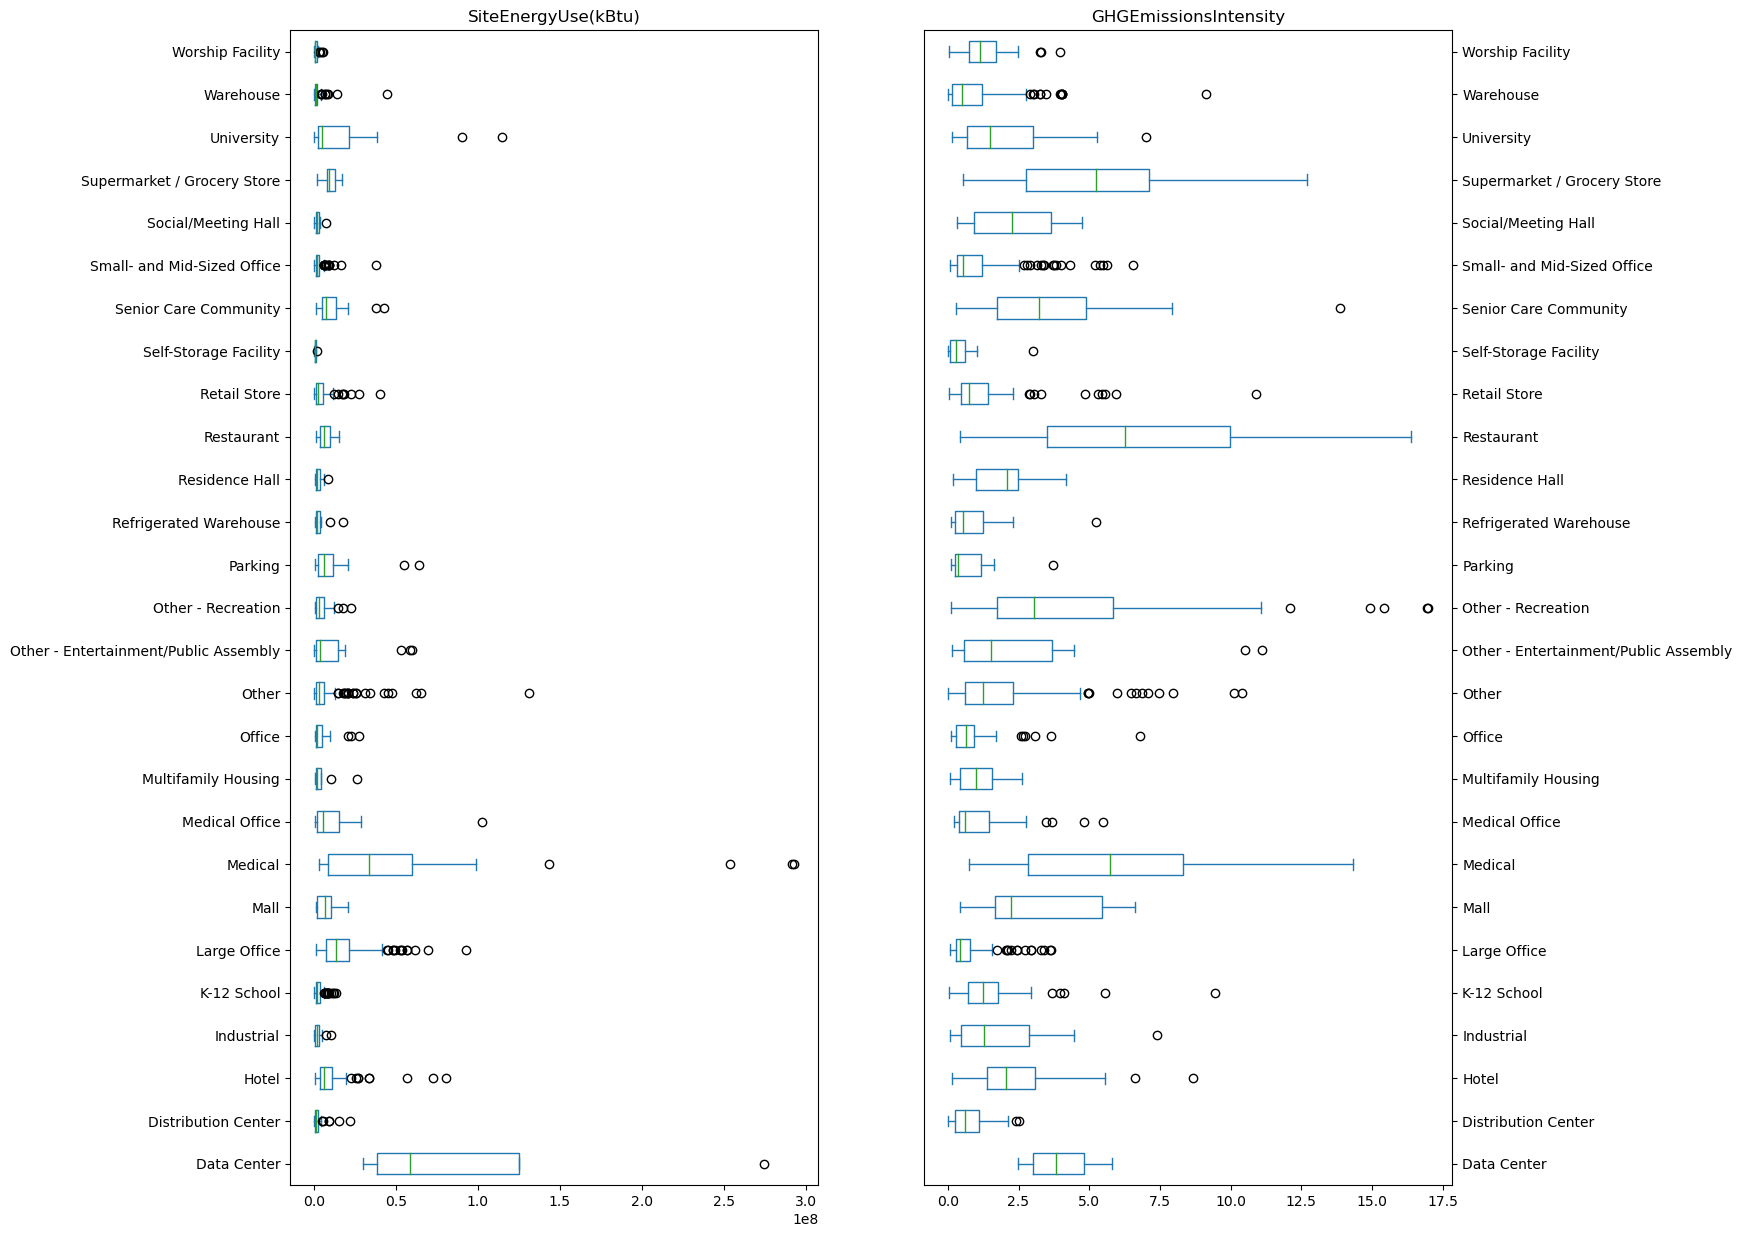

In [90]:
feature1 = features_siteEnergy[2]
feature2 = features_GHG[1]
category1 = features_categories[1]

fig = plt.figure(figsize=(15,15))

ax = plt.subplot(1,2,1)
data_pivot = pd.pivot_table(data_inliers, values=feature1, index=data_inliers.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature1)

ax = plt.subplot(1,2,2)
data_pivot = pd.pivot_table(data_inliers, values=feature2, index=data_inliers.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature2)
ax.yaxis.tick_right()

plt.show()

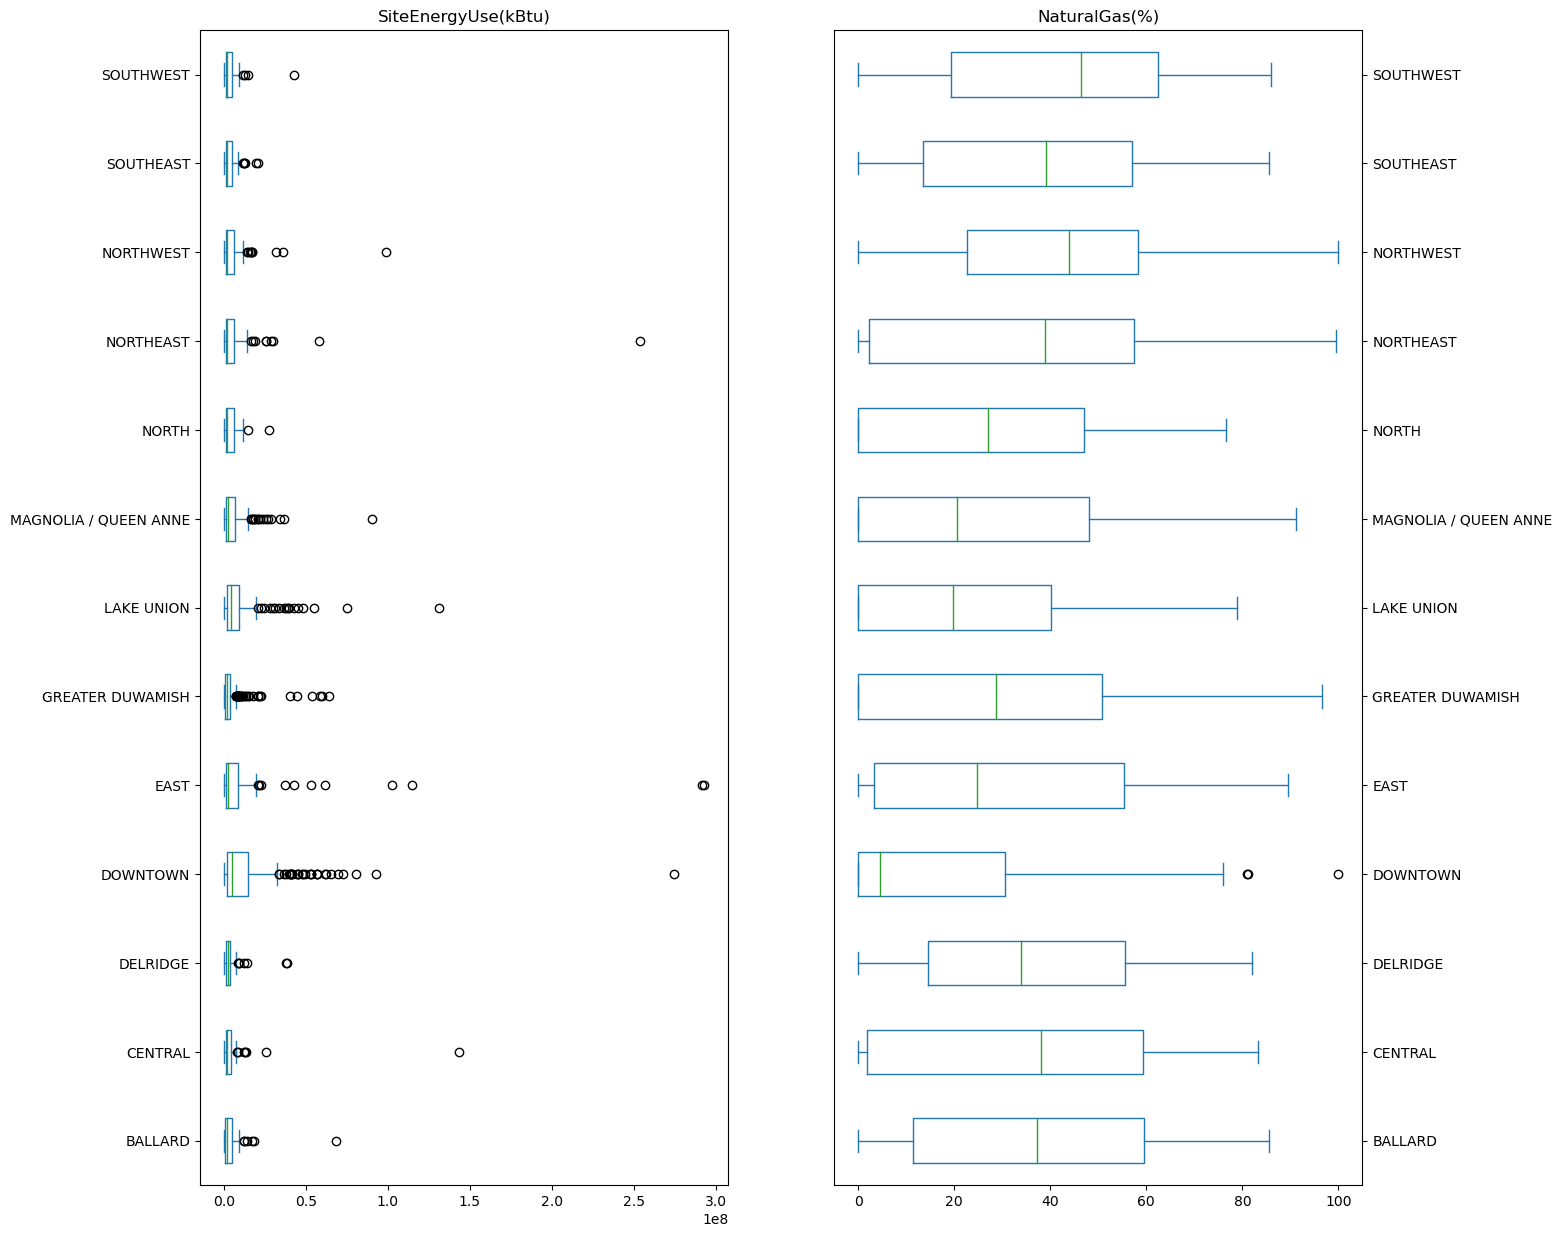

In [91]:
feature1 = features_siteEnergy[2]
feature2 = features_categoriesEnergyProp[2]
category1 = features_geographic[2]

fig = plt.figure(figsize=(15,15))

ax = plt.subplot(1,2,1)
data_pivot = pd.pivot_table(data_inliers, values=feature1, index=data_inliers.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature1)

ax = plt.subplot(1,2,2)
data_pivot = pd.pivot_table(data_inliers, values=feature2, index=data_inliers.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature2)
ax.yaxis.tick_right()

plt.show()

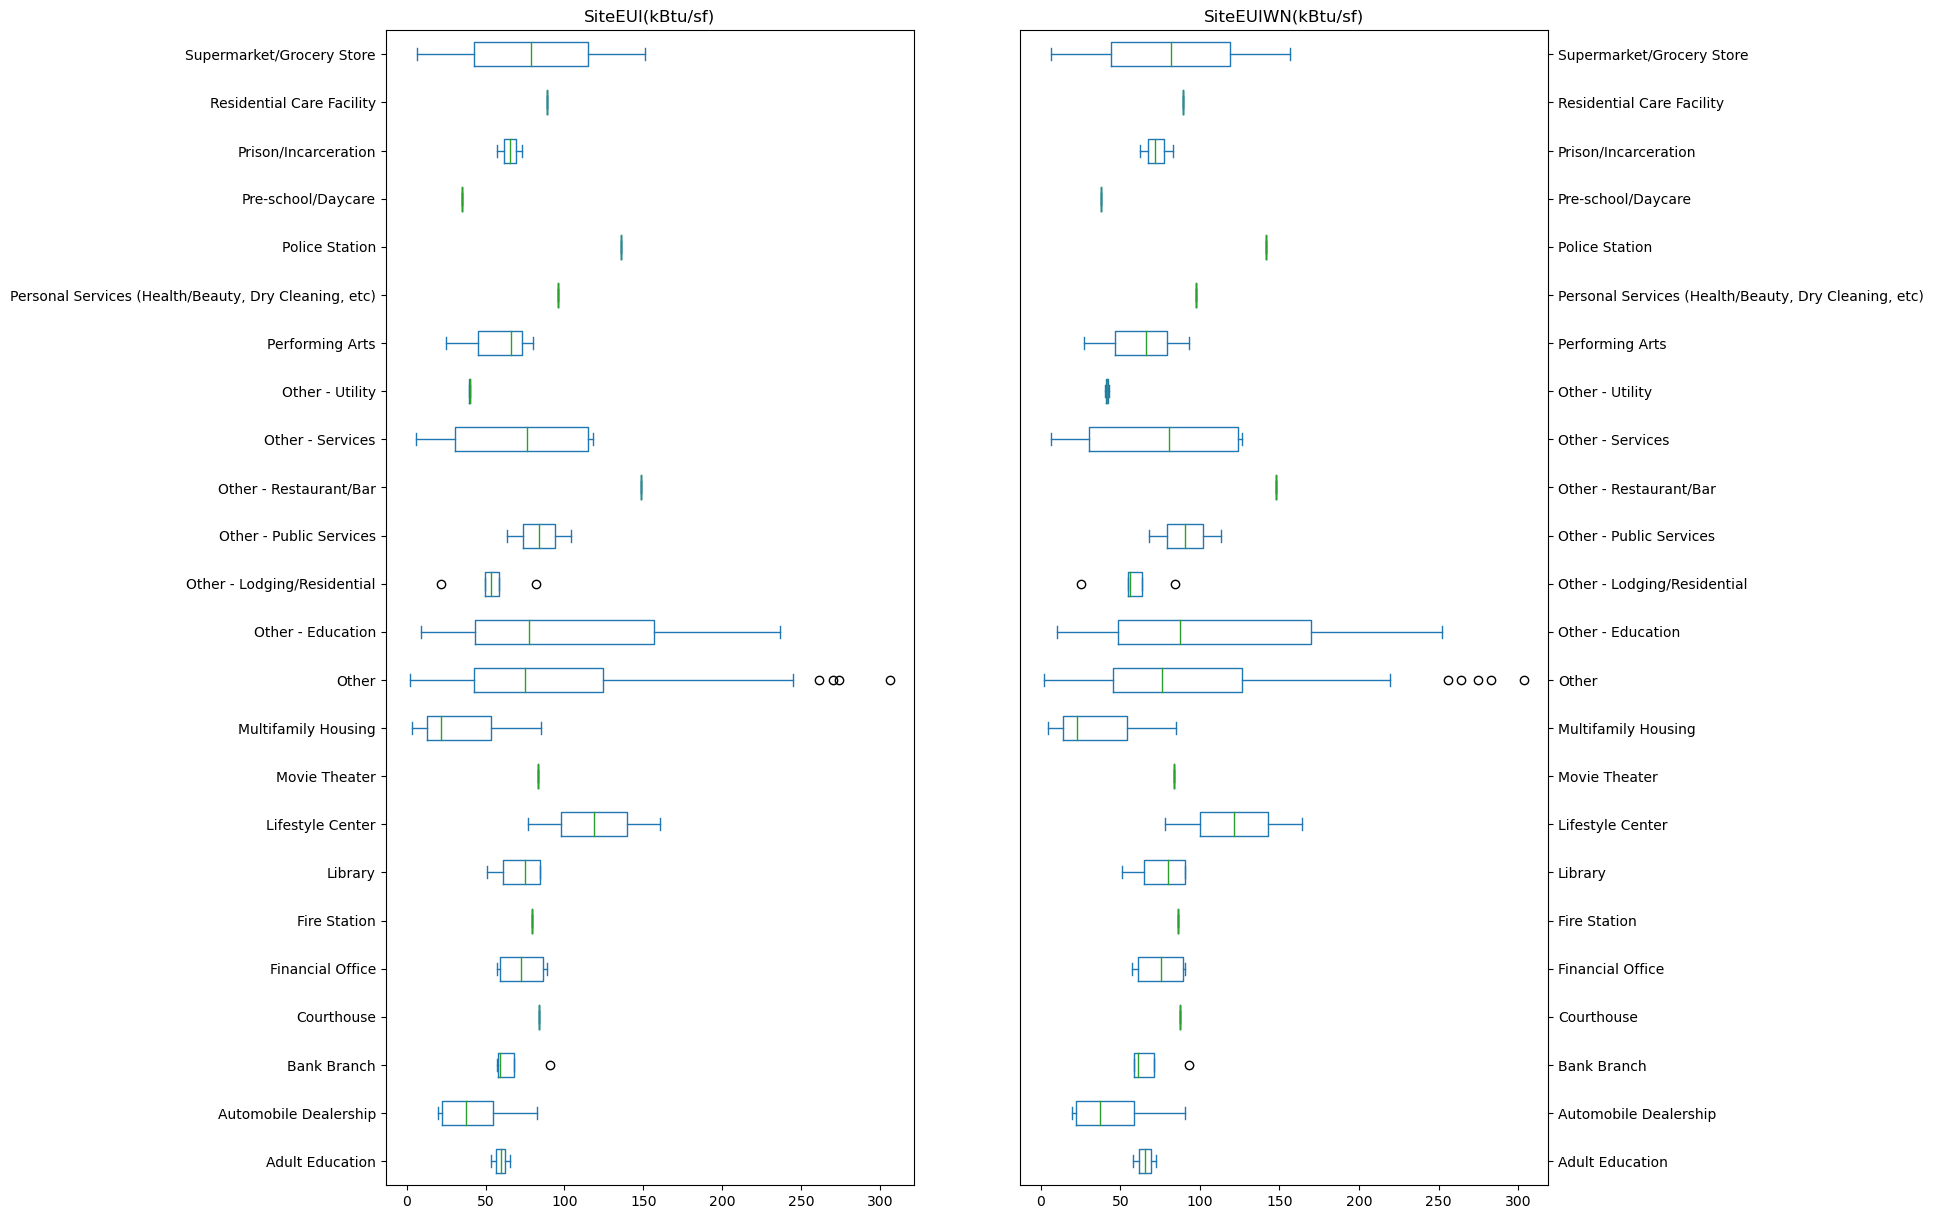

In [92]:
feature1 = features_siteEnergy[0]
feature2 = features_siteEnergy[1]
category1 = features_use[1]
data_plot = data_inliers.loc[data_inliers[features_categories[1]]=='Other']

fig = plt.figure(figsize=(15,15))

ax = plt.subplot(1,2,1)
data_pivot = pd.pivot_table(data_plot, values=feature1, index=data_plot.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature1)

ax = plt.subplot(1,2,2)
data_pivot = pd.pivot_table(data_plot, values=feature2, index=data_plot.index, columns=category1)
data_pivot.plot(ax=ax, kind='box', vert=False)
ax.set_title(feature2)
ax.yaxis.tick_right()

plt.show()

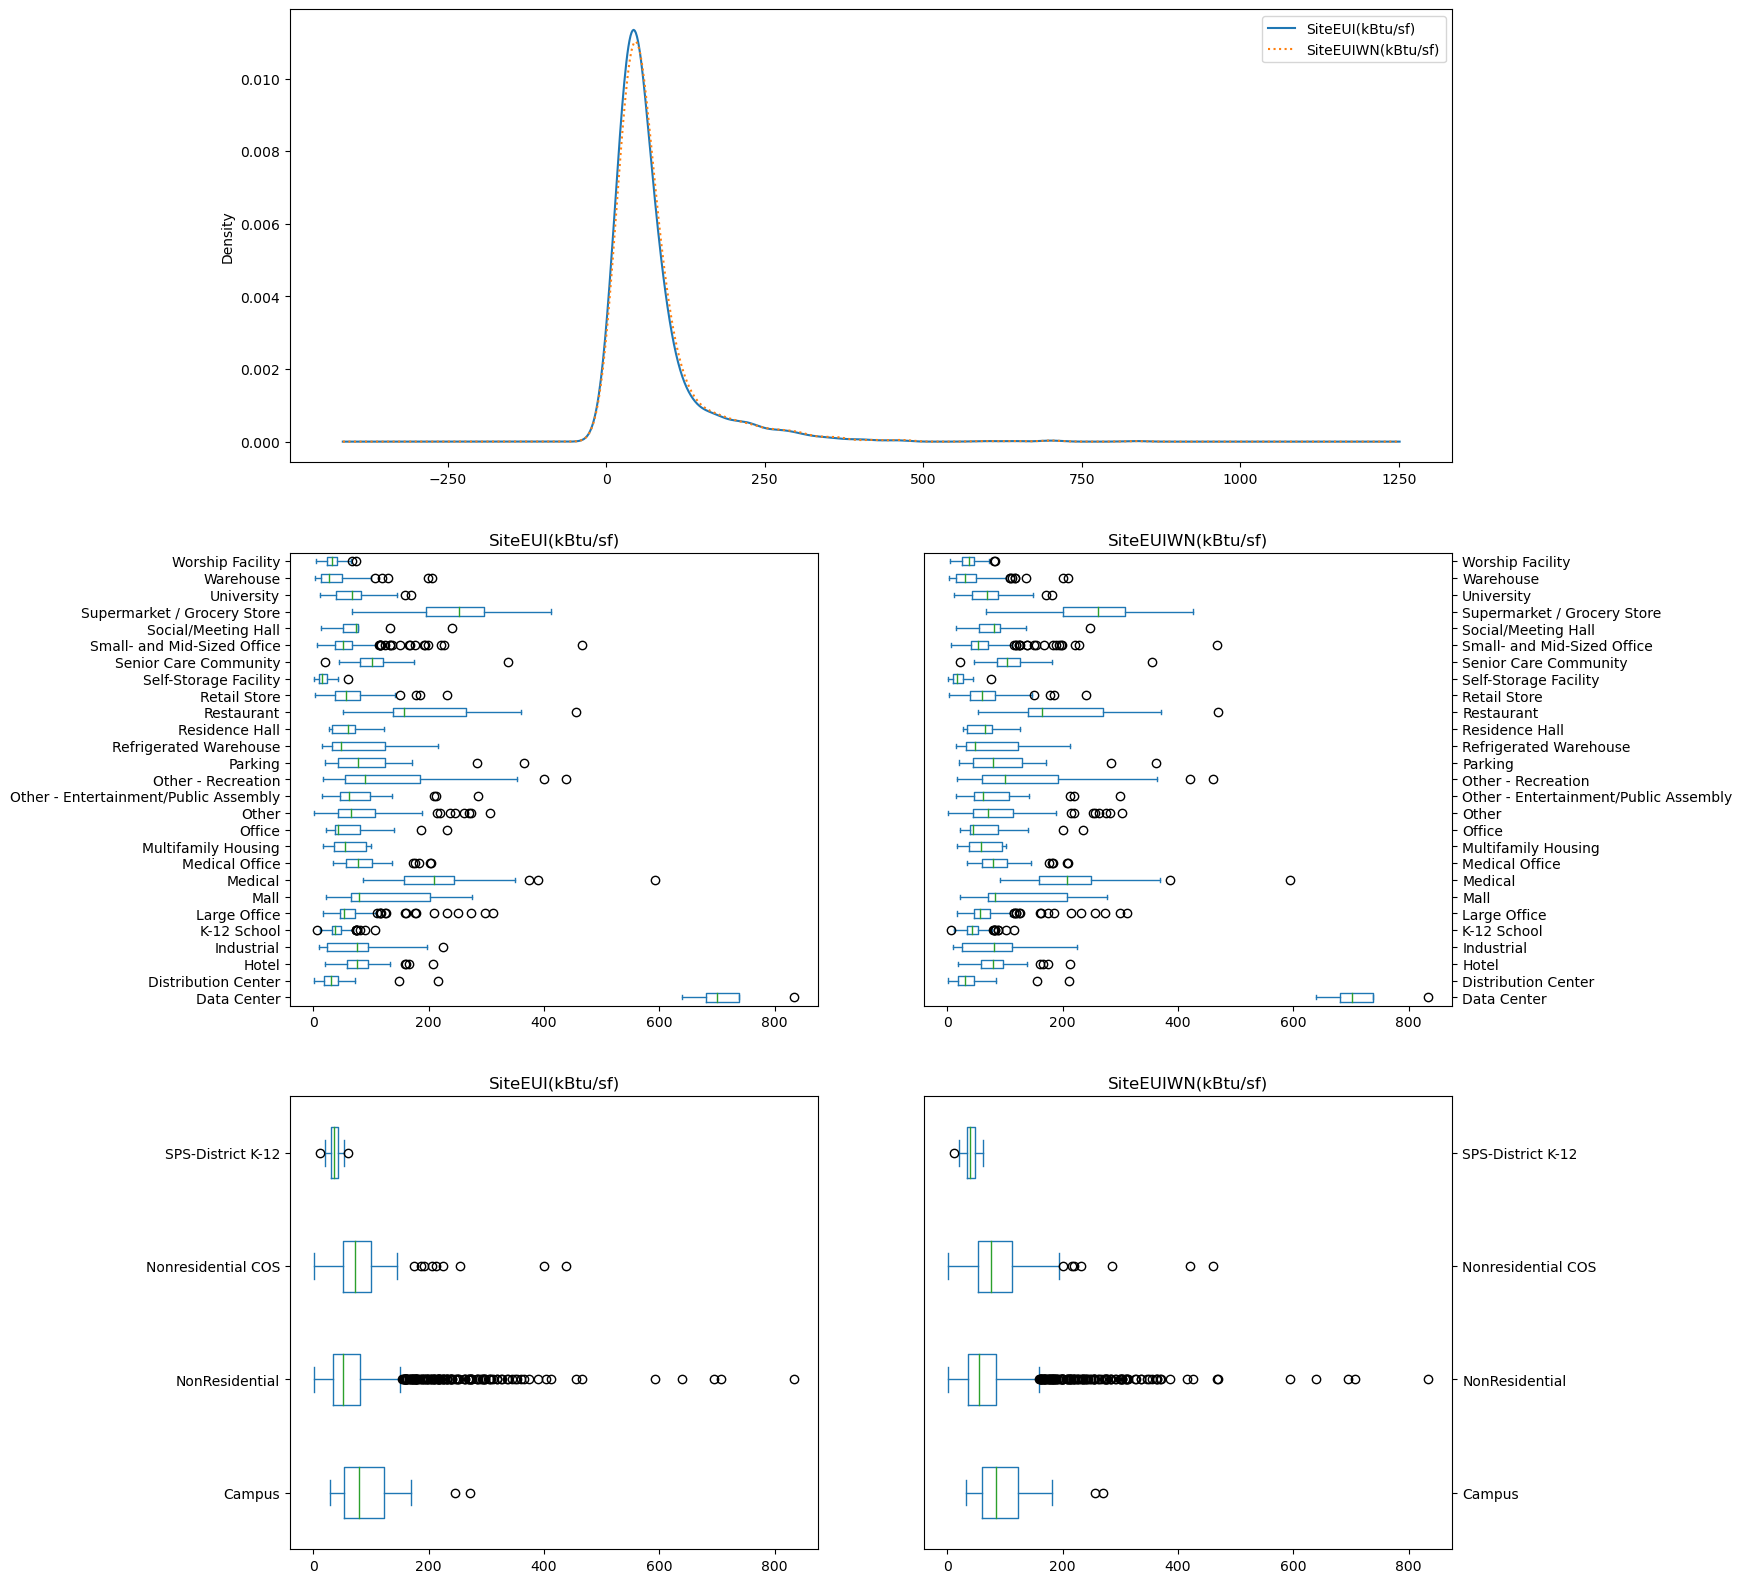

In [93]:
plot_two_features_categories(data_inliers, features_siteEnergy[0], features_siteEnergy[1], features_categories[1], features_categories[0])

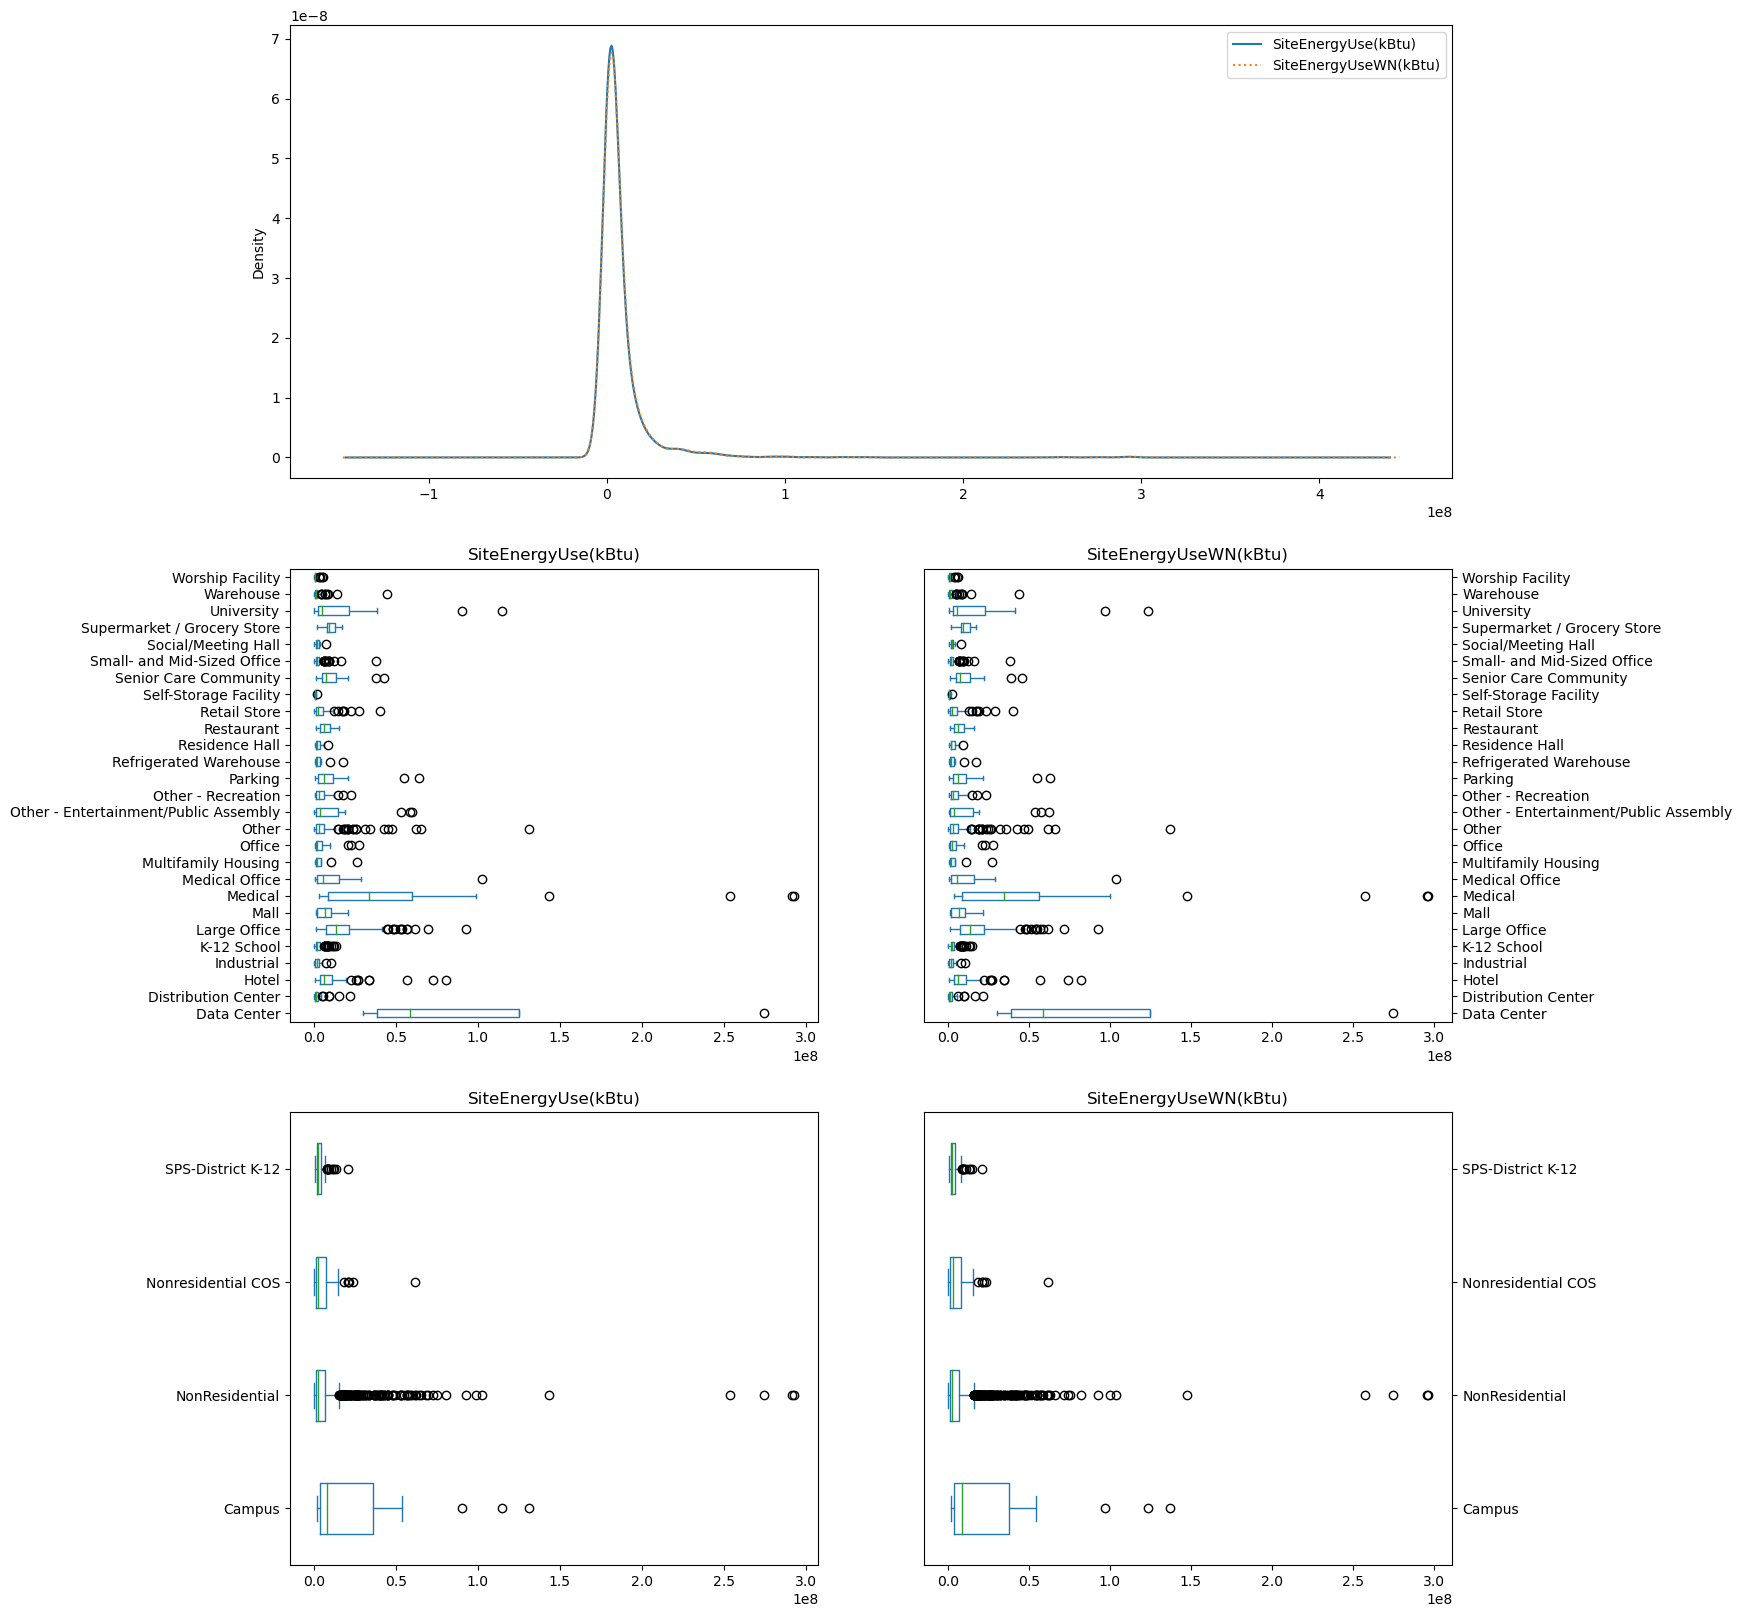

In [94]:
plot_two_features_categories(data_inliers, features_siteEnergy[2], features_siteEnergy[3], features_categories[1], features_categories[0])

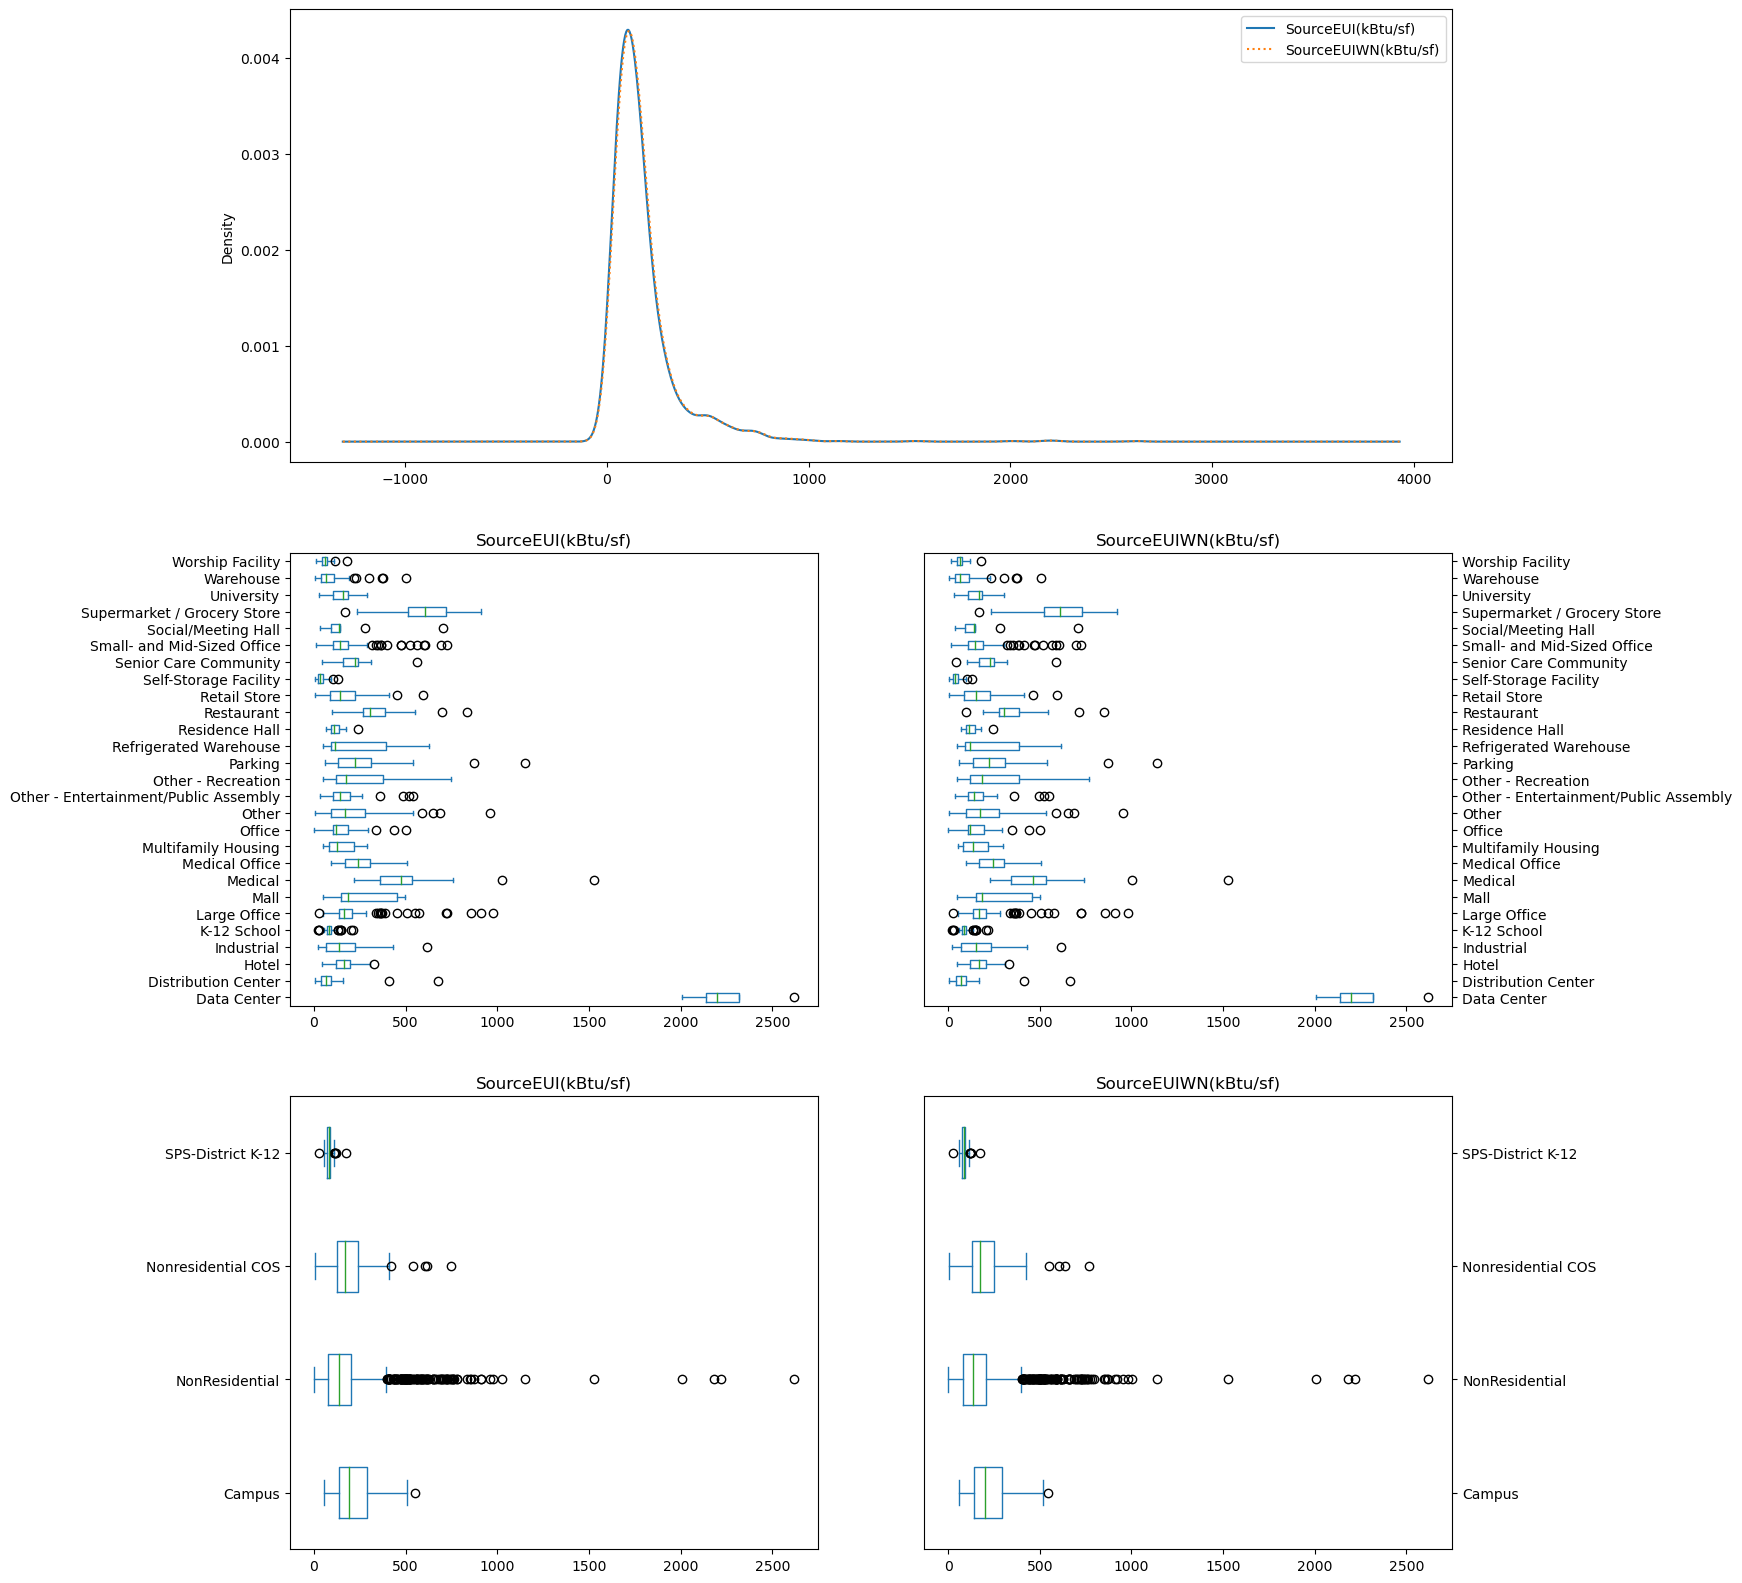

In [95]:
plot_two_features_categories(data_inliers, features_sourceEnergy[0], features_sourceEnergy[1], features_categories[1], features_categories[0])

### Représentation des données géographiques

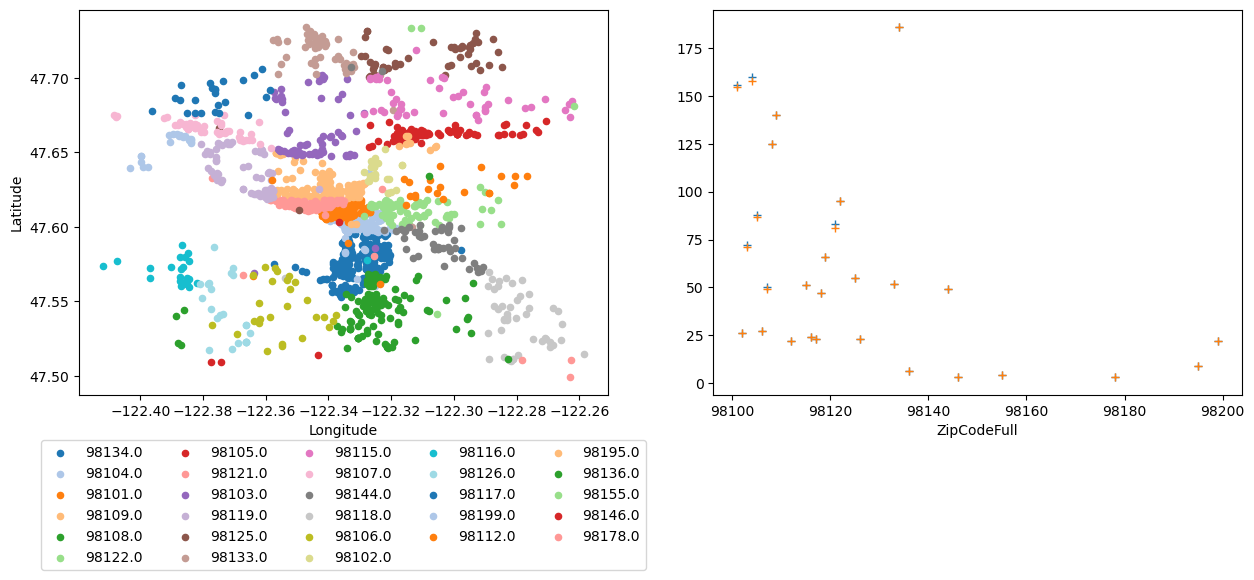

In [96]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
for i in range(len(data_full['ZipCodeFull'].value_counts().index)):
    data_full.loc[data_full['ZipCodeFull']==data_full['ZipCodeFull'].value_counts().index[i]].plot(
        ax=ax, kind='scatter', x='Longitude', y='Latitude',color=plt.cm.tab20.colors[i%20],
        label=data_full['ZipCodeFull'].value_counts().index[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

ax = plt.subplot(1,2,2)
data_nonResidential['ZipCodeFull'].value_counts().plot(ax=ax, linestyle='', marker='+')
data_full['ZipCodeFull'].value_counts().plot(ax=ax, linestyle='', marker='+')

plt.show()

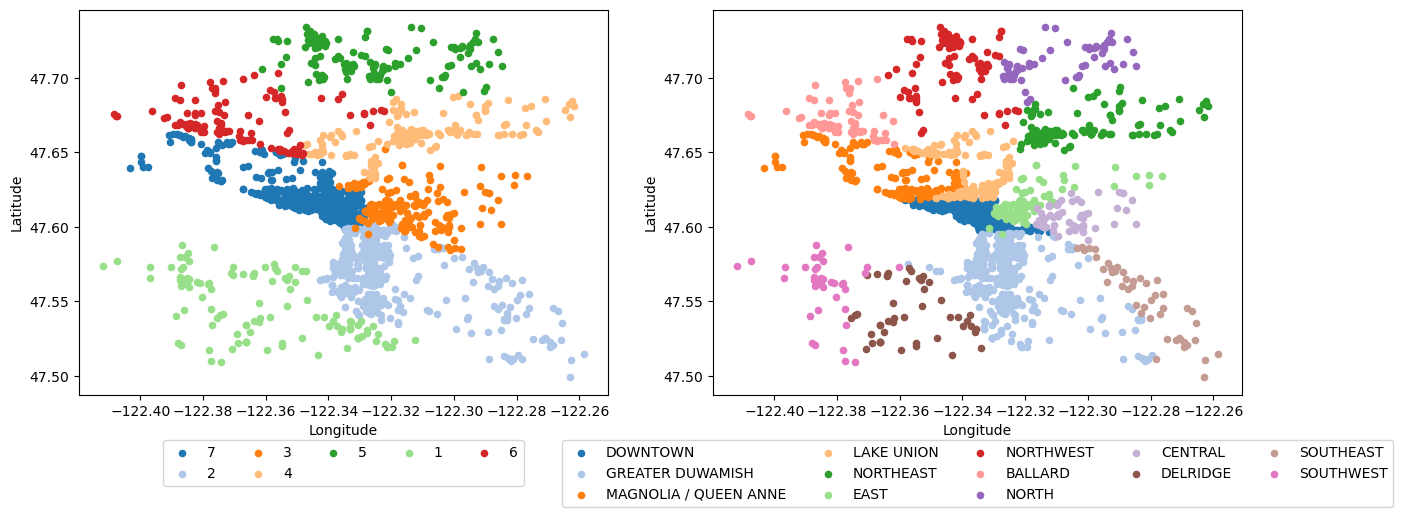

In [97]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
for i in range(len(data_full['CouncilDistrictCode'].value_counts().index)):
    data_full.loc[data_full['CouncilDistrictCode']==data_full['CouncilDistrictCode'].value_counts().index[i]].plot(
        ax=ax, kind='scatter', x='Longitude', y='Latitude',color=plt.cm.tab20.colors[i%20],
        label=data_full['CouncilDistrictCode'].value_counts().index[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

ax = plt.subplot(1,2,2)
for i in range(len(data_full['Neighborhood'].value_counts().index)):
    data_full.loc[data_full['Neighborhood']==data_full['Neighborhood'].value_counts().index[i]].plot(
        ax=ax, kind='scatter', x='Longitude', y='Latitude',color=plt.cm.tab20.colors[i%20],
        label=data_full['Neighborhood'].value_counts().index[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

plt.show()

### Variables annexes

In [98]:
data_full['Outlier'].value_counts()

Outlier
Low outlier     15
High outlier     2
Name: count, dtype: int64

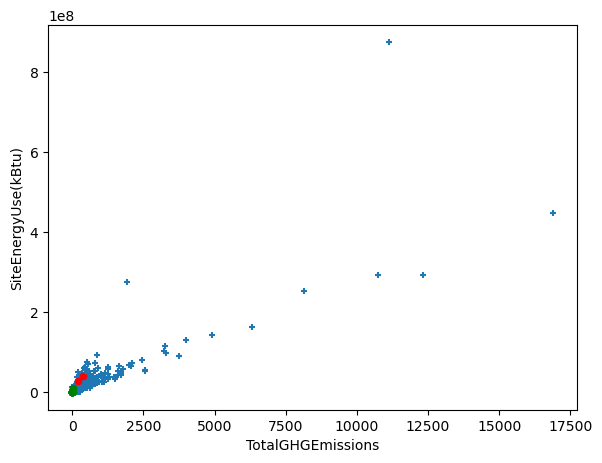

In [99]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
data_full.plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, marker='+')
data_full.loc[data_full['Outlier']=='Low outlier'].plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, color='g')
data_full.loc[data_full['Outlier']=='High outlier'].plot(ax=ax, kind='scatter', x=feature_goal1, y=feature_goal2, color='r')
plt.show()

In [100]:
data_full['DefaultData'].value_counts()

DefaultData
False    1571
True       88
Name: count, dtype: int64

In [101]:
data_full['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       1542
Error - Correct Default Data      88
Non-Compliant                     15
Missing Data                      14
Name: count, dtype: int64

# Sélection des données pour la prédiction

In [102]:
pred_quantitatives = np.concatenate((features_architecture,features_GFA))
pred_quantitatives = np.concatenate((pred_quantitatives,features_categoriesEnergyProp))

In [103]:
pred_qualitatives = np.concatenate((features_categories, features_geographic))

In [104]:
data_pred = data_inliers[pred_quantitatives].copy()

In [105]:
data_pred_variables = pred_quantitatives
data_pred_int_variables = np.concatenate(([features_architecture[0]],features_categoriesEnergyProp))

In [106]:
for string in pred_qualitatives:
    for value in data_inliers[string].unique():
        data_pred[string+"_"+str(value)] = (data_inliers[string]==value).astype(int)
        data_pred_variables = np.concatenate((data_pred_variables, [string+"_"+str(value)]))
        data_pred_int_variables = np.concatenate((data_pred_int_variables, [string+"_"+str(value)]))

In [107]:
data_pred['goal1'] = data_inliers[feature_goal1]
data_pred['goal2'] = data_inliers[feature_goal2]

In [108]:
data_pred['goal1_int'] = data_inliers[feature_goal1_int]
data_pred['goal2_int'] = data_inliers[feature_goal2_int]
data_pred['s_int'] = data_inliers[features_GFA[0]]

In [109]:
data_pred[features_starScore] = data_inliers[features_starScore]

In [110]:
data_pred.shape

(1562, 94)

In [111]:
data_pred_int = data_inliers[np.concatenate(([features_architecture[0]],features_categoriesEnergyProp))].copy()

In [112]:
for string in features_categories:
    for value in data_inliers[string].unique():
        data_pred_int[string+"_"+str(value)] = (data_inliers[string]==value).astype(int)

In [113]:
data_pred_int[features_starScore] = data_inliers[features_starScore]

In [114]:
data_pred_int.shape

(1562, 36)

In [115]:
data_pred.to_csv('data_pred.csv', index_label='index')
np.savetxt('data_pred_variables.csv', data_pred_variables, fmt="%s")
np.savetxt('data_pred_int_variables.csv', data_pred_int_variables, fmt="%s")

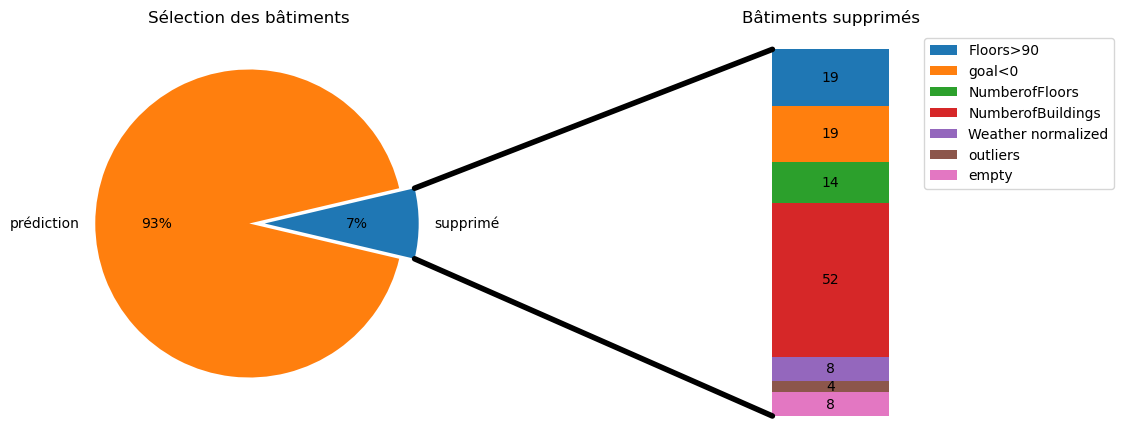

In [118]:
from matplotlib.patches import ConnectionPatch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(wspace=0)

wedges, *_ = ax1.pie([np.sum(list(bat_filter_dict.values())), len(data_inliers)], autopct='%1.0f%%',
                     startangle=-180*np.sum(list(bat_filter_dict.values()))/(np.sum(list(bat_filter_dict.values()))+len(data_inliers)),
                     labels=['supprimé', 'prédiction'], explode=[0.1, 0])
ax1.set_title('Sélection des bâtiments')

bottom=np.sum(list(bat_filter_dict.values()))
width=0.2
for j, (height, label) in enumerate(reversed([*zip(list(bat_filter_dict.values()), list(bat_filter_dict.keys()))])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, label=label)
    ax2.bar_label(bc, labels=[f"{height:d}"], label_type='center')

ax2.set_title('Bâtiments supprimés')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = np.sum(list(bat_filter_dict.values()))

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()